# Open Problems – Single-Cell Perturbations

## Punto 2: base de datos 2


## Librerías

In [ ]:
!pip install -q condacolab
import condacolab

In [ ]:
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!mamba install -c conda-forge rdkit

In [ ]:
!pip install missingno
!pip install statsmodels

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy import stats
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/Data

In [5]:
ls

adata_excluded_ids.csv  condacolab_install.log  multiome_obs_meta.csv   sample_submission.csv
adata_obs_meta.csv      de_train.parquet        multiome_train.parquet
adata_train.parquet     id_map.csv              multiome_var_meta.csv


## Importar bases


In [ ]:
adata_obs = pd.read_csv('adata_obs_meta.csv')

In [ ]:
adata_train = pd.read_parquet('adata_train.parquet')

In [10]:
de_train = pd.read_parquet('de_train.parquet')

## Sobre los datos



La biología humana es compleja por a la interacción entre los aproximadamente 37 billones de células del cuerpo, organizadas en tejidos, órganos y sistemas. Los avances en tecnologías de células individuales han permitido una visión detallada de las funciones celulares a nivel de ADN, ARN y proteínas.

Sin embargo, desarrollar nuevos medicamentos requiere mapear los efectos de perturbaciones químicas en el estado celular, lo que puede ser costoso y laborioso. La ciencia de datos podría acelerar este proceso si pudiera predecir perturbaciones en nuevos tipos celulares.

Aunque existen métodos avanzados, como los basados en autoencoders, estos enfrentan limitaciones debido a la falta de conjuntos de datos diversos y representativos. La disponibilidad de datos más completos y variados es crucial para mejorar la precisión de las predicciones y avanzar en el desarrollo de nuevos tratamientos.

Para estos datos, se diseñó y generó un nuevo conjunto de datos de perturbaciones a nivel de célula única en células mononucleares de sangre periférica humana (PBMCs). Se seleccionaron 144 compuestos del conjunto de datos LINCS Connectivity Map y se midieron los perfiles de expresión génica a nivel de célula única tras 24 horas de tratamiento. El experimento se repitió en tres donantes humanos sanos, eligiendo los compuestos en función de firmas transcripcionales diversas observadas en células madre hematopoyéticas CD34+ (datos no publicados). Las PBMCs fueron elegidas debido a su disponibilidad comercial, consentimiento para liberación pública y su relevancia como tejido primario que contiene varios tipos celulares maduros (células T, B, mieloides y NK) con marcadores establecidos para anotación.

[Open Problems – Single-Cell Perturbations](https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/data)






### de_train

`de_train` contiene 614 registros con datos agregados de expresión diferencial, lo que permite estimar el impacto de una perturbación experimental en el nivel de expresión de cada gen (18,211 genes en este conjunto de datos). Para esto, se promediaron los conteos de expresión génica crudos en cada célula de un tipo específico en cada muestra, "pseudobulking" (se suman los conteos crudos de todas las células de un tipo dado para cada pozo en el experimento).

 Este archivo contiene los datos principales, con valores de expresión diferencial agregados para diferentes combinaciones de tipos de células y nombres de compuestos, los cuales reflejan cómo cambia la expresión génica entre las condiciones de tratamiento y control.

In [ ]:
de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [ ]:
de_train.describe(include='all')

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
count,614,614,614,614,614,614.000000,614.000000,614.000000,614.000000,614.000000,...,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
unique,6,146,146,146,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NK cells,Penfluridol,LSM-2334,OC1(c2ccc(Cl)c(C(F)(F)F)c2)CCN(CCCC(c2ccc(F)cc...,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,146,6,6,6,602,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.366769,0.250951,0.148259,0.155733,0.684275,...,0.071179,0.159252,0.018584,0.267114,0.497043,0.382672,0.240726,0.161087,-0.160735,-0.071255
std,NaN,NaN,NaN,NaN,NaN,1.634697,1.188660,2.275410,2.184095,3.189206,...,1.028842,1.128245,1.333236,1.439952,1.691722,1.430553,0.918039,0.779918,0.932961,0.748377
min,NaN,NaN,NaN,NaN,NaN,-3.258689,-4.067518,-28.552191,-17.801989,-6.378904,...,-4.309438,-4.276411,-21.273505,-5.520507,-6.780020,-2.617712,-8.310726,-3.456731,-7.189487,-4.819105
25%,NaN,NaN,NaN,NaN,NaN,-0.215161,-0.267728,-0.230129,-0.229460,-0.190989,...,-0.349490,-0.289498,-0.421265,-0.275030,-0.119912,-0.135779,-0.141982,-0.169364,-0.479099,-0.402733
50%,NaN,NaN,NaN,NaN,NaN,0.082722,0.102076,0.044717,0.036156,0.116411,...,0.010186,0.063539,-0.010158,0.065780,0.148876,0.145279,0.137559,0.062804,-0.083260,-0.058601
75%,NaN,NaN,NaN,NaN,NaN,0.528015,0.523162,0.405858,0.532216,0.616725,...,0.330117,0.479763,0.361876,0.482989,0.683587,0.600652,0.510566,0.487592,0.266170,0.252387


No se notan datos faltantes según el count de la descripción.

In [ ]:
de_train['cell_type'].unique()

array(['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells',
       'B cells', 'Myeloid cells'], dtype=object)

In [ ]:
de_train['cell_type'].value_counts()

,count
cell_type,
NK cells,146
T cells CD4+,146
T regulatory cells,146
T cells CD8+,142
B cells,17
Myeloid cells,17


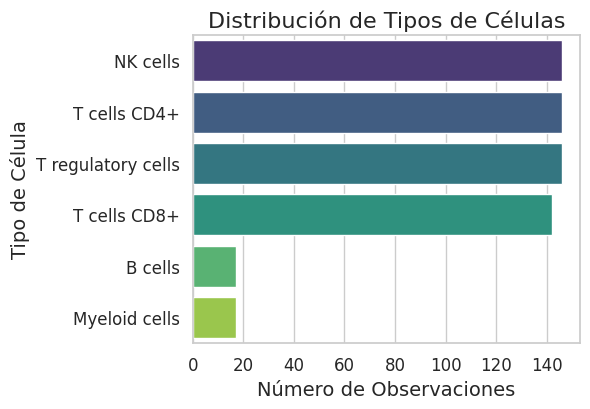

In [ ]:
sns.set(style='whitegrid')

plt.figure(figsize=(5, 4))
ax = sns.countplot(data=de_train, y='cell_type', palette='viridis', order=de_train['cell_type'].value_counts().index)

ax.set_title('Distribución de Tipos de Células', fontsize=16)
ax.set_xlabel('Número de Observaciones', fontsize=14)
ax.set_ylabel('Tipo de Célula', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

Este cuenta con 614 filas y 18216 columnas. `cell_type` corresponde al tipo de célula anotado basado en la expresión de RNA, en total hay seis tipos de célula: *NK* (146), *T CD4+* (146), *T CD8+* (146), *T regulatorias* (142), *B* (17) y *mieloides* (17).


Las **células NK** son parte del sistema inmunológico innato y destruyen células infectadas o cancerosas. Las células **T CD4+** ayudan a coordinar la respuesta inmune activando otras células, mientras que las células **T CD8+** eliminan células infectadas por virus o tumorales. Las **células T reguladoras** mantienen el equilibrio del sistema inmune para evitar enfermedades autoinmunes. **Las células B** producen anticuerpos y juegan un rol en la memoria inmunológica. Por último, **las células mieloides** incluyen macrófagos y otras células que participan en la respuesta inmune innata y en la presentación de antígenos a las células T.

`sm_name` es una variable categórica que contiene el nombre del principal del compuesto (principal) y cuenta con 146 compuestos diferentes.

In [ ]:
de_train['sm_name'].value_counts()

,count
sm_name,
Penfluridol,6
Dabrafenib,6
O-Demethylated Adapalene,6
Palbociclib,6
Porcn Inhibitor III,6
...,...
Prednisolone,4
Tamatinib,4
CC-401,4


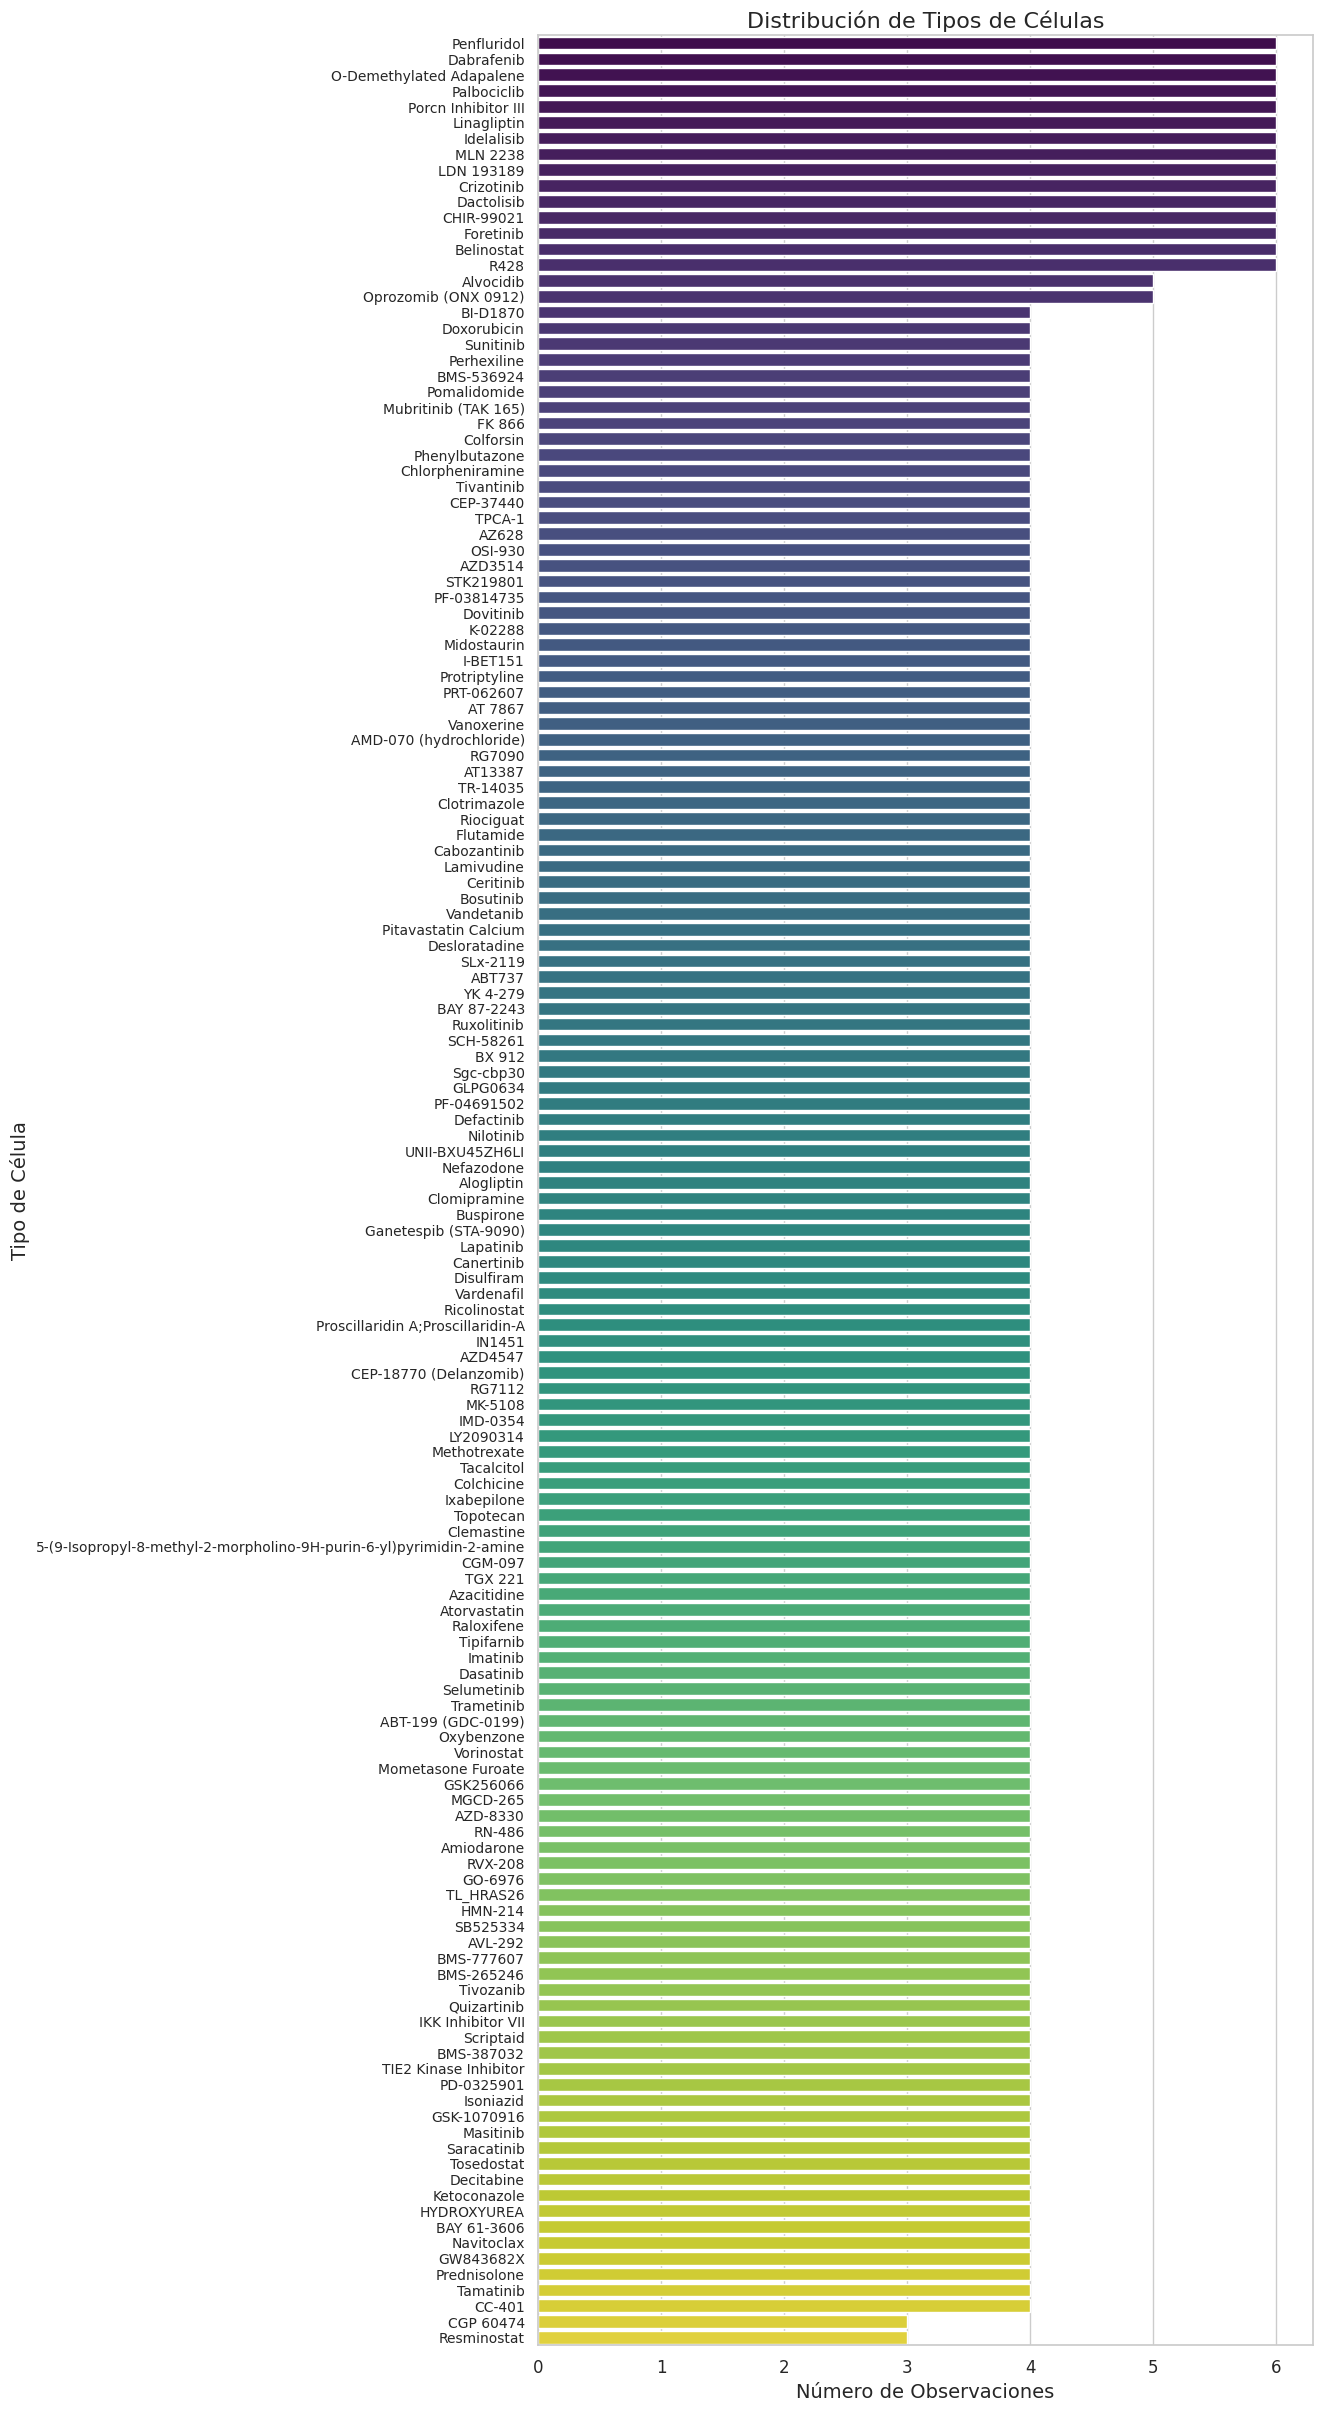

In [ ]:
sns.set(style='whitegrid')

plt.figure(figsize=(10, 30))
ax = sns.countplot(data=de_train, y='sm_name', palette='viridis', order=de_train['sm_name'].value_counts().index)

ax.set_title('Distribución de Tipos de Células', fontsize=16)
ax.set_xlabel('Número de Observaciones', fontsize=14)
ax.set_ylabel('Tipo de Célula', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

plt.show()

Viendo la gráfica se puede notar que las moléculas pequeñas más comunes dentro del dataset son: **Penfluridol** (6), antipsicótico utilizado para tratar la esquizofrenia, **Dabrafenib** (6), inhibidor de la proteína BRAF utilizado en el tratamiento de melanomas con mutaciones en BRAF. **O-Demethylated Adapalene ** (6), un retinoide empleado para el acné. **Palbociclib** (6), utilizado en cáncer de mama avanzado con receptores hormonales positivos y **Porcn Inhibitor III** (6), un inhibidor de la proteína Porcupine, que se investiga en el tratamiento de ciertos cánceres.

`sm_lincs_id` es ID global de LINCS para el compuesto principal en una representación estandarizada para mapear los datos con los datos del Connectivity Map de LINCS. `SMILES` es una representación 1D de la estructura molecular de los compuestos utilizados.

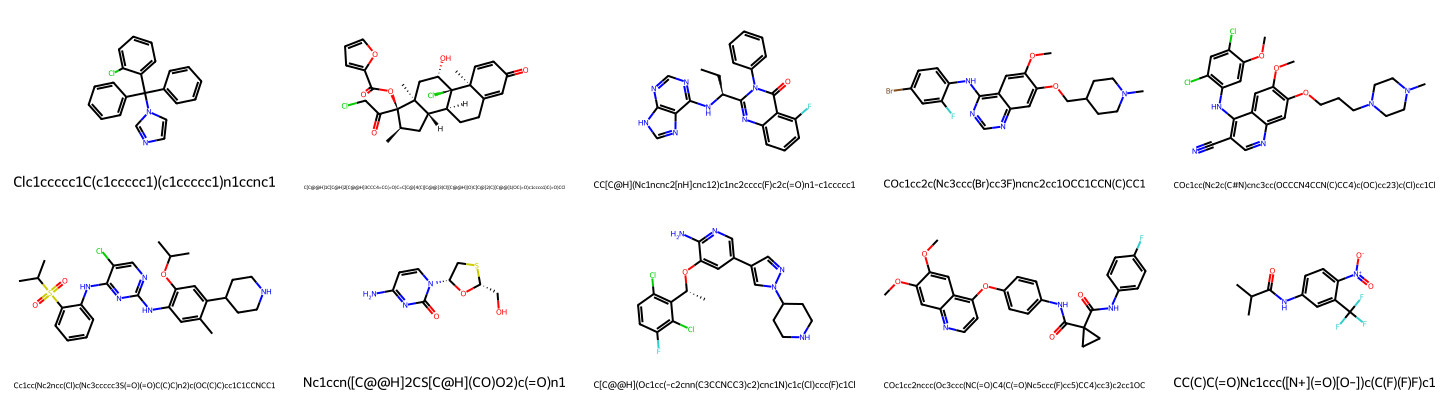

In [ ]:
smiles_u = de_train['SMILES'].unique()[:10]
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_u]
legends = [smiles for smiles in smiles_u]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(290, 200), legends=legends)
display(img)

Estas representan la estructura de 10 de las diferentes 146 moléculas (compuestos) representadas en la variable `SMILES`.

 Y `control` es un boolean que indica si ese registro se utilizó como control, en total se tomaron 12 registros de control, 2 por cada tipo de célula.

In [ ]:
de_train['control'].value_counts()

,count
control,
False,602
True,12


In [ ]:
de_train.groupby(['control', 'cell_type']).size().unstack(fill_value=0)

cell_type,B cells,Myeloid cells,NK cells,T cells CD4+,T cells CD8+,T regulatory cells
control,,,,,,
False,15,15,144,144,140,144
True,2,2,2,2,2,2


Por último, las variables etiquetadas como `A1BG`, `A1BG-AS1`, …, `ZZEF1` (18,211) son los valores de expresión diferencial para cada gen.

In [ ]:
de_train.iloc[:, 5:].abs().max().sort_values(ascending=False).head()


,0
ADI1,180.519202
STMN1,179.324177
SRSF5,176.821614
METRN,162.088860
EMP3,161.476073


In [ ]:
de_train.iloc[:, 5:].abs().max().sort_values(ascending=False).tail()

,0
VHL,2.925482
R3HCC1,2.787605
AKT2,2.758655
CAAP1,2.696201
ZFC3H1,2.533461


Aquellos genes con valores más grandes de expresiones diferencial (valor absoluto) son ADI (181.5), STMN1 (179.32) y SRSF5 (176.8), esto sugiere que el gen está significativamente afectado por el tratamiento o la perturbación experimental. Y los que tiene valores más pequeños de expresión diferencial son AKT2 (2.75), CAAP1 (2.69) y ZFC3H1 (2.53), es decir, el gen podría no estar significativamente afectado por la perturbación experimental o que el nivel de DE es relativamente estable.


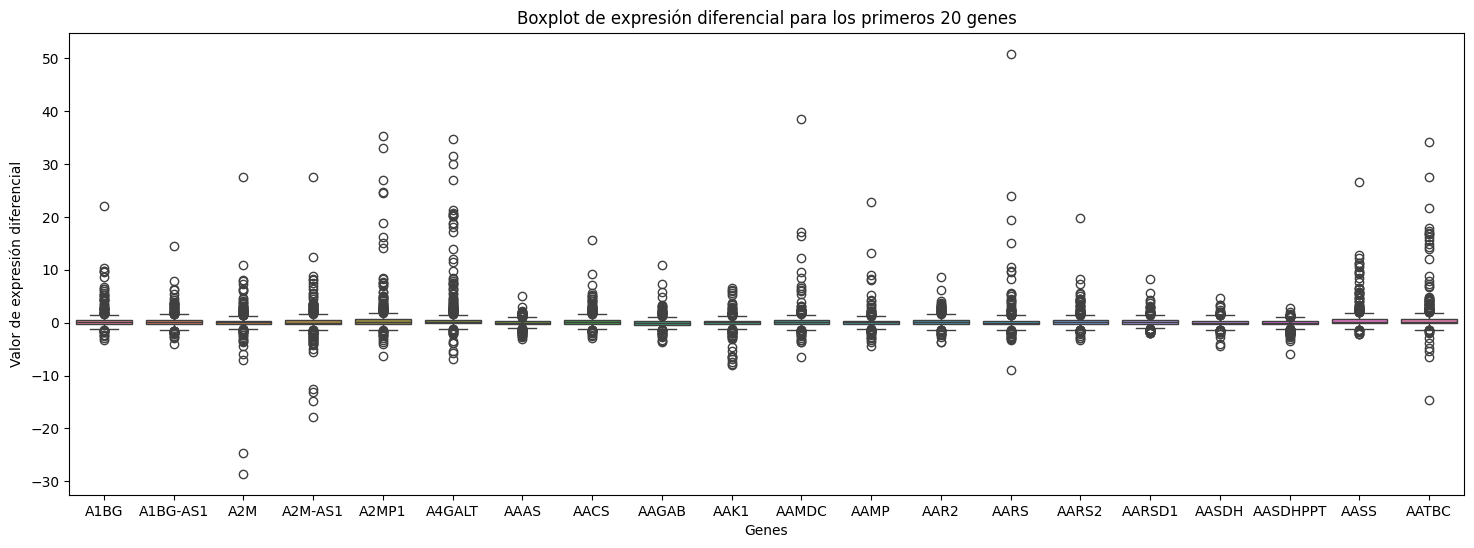

In [ ]:
df_genes = de_train.iloc[:,5:25]

plt.figure(figsize=(18, 6))
sns.boxplot(data=df_genes)
plt.title('Boxplot de expresión diferencial para los primeros 20 genes')
plt.xlabel('Genes')
plt.ylabel('Valor de expresión diferencial')
plt.show()

In [ ]:
df_genes.describe(include = 'all')

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATBC
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.366769,0.250951,0.148259,0.155733,0.684275,0.946273,0.000582,0.348203,0.009424,0.062662,0.297573,0.143820,0.200386,0.279041,0.214915,0.200211,0.042302,-0.099249,0.651305,0.794079
std,1.634697,1.188660,2.275410,2.184095,3.189206,3.826391,0.703410,1.259422,0.952243,1.237806,2.201196,1.456376,0.953456,2.778114,1.358248,0.835510,0.758942,0.713714,2.041962,3.129761
min,-3.258689,-4.067518,-28.552191,-17.801989,-6.378904,-6.908058,-3.167504,-2.825505,-3.654218,-8.042101,-6.560442,-4.387723,-3.727657,-8.912199,-3.312784,-2.017474,-4.398344,-5.958244,-2.219594,-14.569670
25%,-0.215161,-0.267728,-0.230129,-0.229460,-0.190989,-0.123963,-0.261792,-0.197019,-0.356774,-0.214164,-0.265882,-0.259882,-0.204153,-0.336113,-0.278050,-0.162441,-0.302344,-0.330409,-0.092588,-0.101920
50%,0.082722,0.102076,0.044717,0.036156,0.116411,0.131515,0.009045,0.144223,-0.028306,0.068134,0.067098,0.058913,0.078106,-0.012606,0.054175,0.106285,0.022857,-0.014256,0.201071,0.172394
75%,0.528015,0.523162,0.405858,0.532216,0.616725,0.580870,0.268029,0.560221,0.253911,0.413308,0.448335,0.377015,0.526927,0.369443,0.427910,0.473518,0.396103,0.232350,0.697741,0.703207
max,22.085428,14.421991,27.557166,27.603715,35.278040,34.785942,5.079223,15.589494,10.855080,6.518868,38.497828,22.881296,8.630325,50.858146,19.791957,8.309339,4.763672,2.836872,26.593134,34.210716


In [ ]:
df_sin_outliers = de_train.iloc[:,5:]
for col in df_sin_outliers.columns:
    Q1 = df_sin_outliers[col].quantile(0.25)
    Q3 = df_sin_outliers[col].quantile(0.75)
    IQR = Q3 - Q1

    is_outlier = (df_sin_outliers[col] < (Q1 - 1.5 * IQR)) | (df_sin_outliers[col] > (Q3 + 1.5 * IQR))

    df_sin_outliers.loc[is_outlier, col] = None

df_sin_outliers.describe(include='all').iloc[:,5:25]

,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATBC,AATF,AATK,ABALON,ABAT,ABCA1
count,526.000000,547.000000,547.000000,566.000000,543.000000,550.000000,560.000000,566.000000,549.000000,547.000000,565.000000,574.000000,553.000000,553.000000,541.000000,575.000000,529.000000,540.000000,568.000000,539.000000
mean,0.126774,0.010119,0.151256,-0.058975,0.081959,0.062158,0.044560,0.118859,-0.006774,0.036197,0.148552,0.032821,-0.022420,0.233732,0.210329,-0.096757,0.163896,0.166517,0.134932,0.068465
std,0.497671,0.398823,0.556984,0.456573,0.455817,0.531333,0.469221,0.559692,0.539432,0.532863,0.490897,0.533163,0.426461,0.572820,0.553924,0.598966,0.498095,0.523571,0.547409,0.538284
min,-1.166084,-1.024258,-1.178222,-1.272353,-1.126649,-1.311335,-1.213436,-1.288293,-1.392970,-1.308893,-1.061653,-1.346567,-1.149143,-1.213228,-1.296400,-1.687830,-0.971589,-1.260480,-1.254942,-1.315550
25%,-0.138929,-0.205469,-0.193586,-0.329127,-0.183455,-0.244178,-0.210963,-0.198059,-0.293827,-0.265025,-0.143015,-0.270595,-0.270269,-0.108690,-0.113690,-0.427779,-0.119068,-0.134875,-0.191373,-0.237490
50%,0.076647,0.009985,0.108107,-0.031284,0.064777,0.039071,0.058393,0.053226,-0.020291,0.038826,0.099800,0.021432,-0.005129,0.166950,0.131233,-0.054579,0.094900,0.114967,0.088564,0.038124
75%,0.372059,0.231414,0.412828,0.213915,0.333150,0.345217,0.324568,0.441997,0.285838,0.353822,0.432134,0.345439,0.224668,0.524667,0.488845,0.258116,0.417148,0.435632,0.439578,0.344342
max,1.522304,1.049887,1.645047,1.165461,1.323083,1.463941,1.286977,1.598289,1.408554,1.477425,1.410802,1.439275,1.052300,1.879452,1.889033,1.437032,1.684622,1.736742,1.576497,1.465007


Aquí se puede observar la distribución de la expresión diferencial de los primeros 25 genes, limitado debido al costo computacional de gráficar esta información para todos los genes. Es notorio también la presencia de muchos datos atípicos en todos los boxplots. En cuanto a la distribución, omitiendo outliers, es bastante similar.

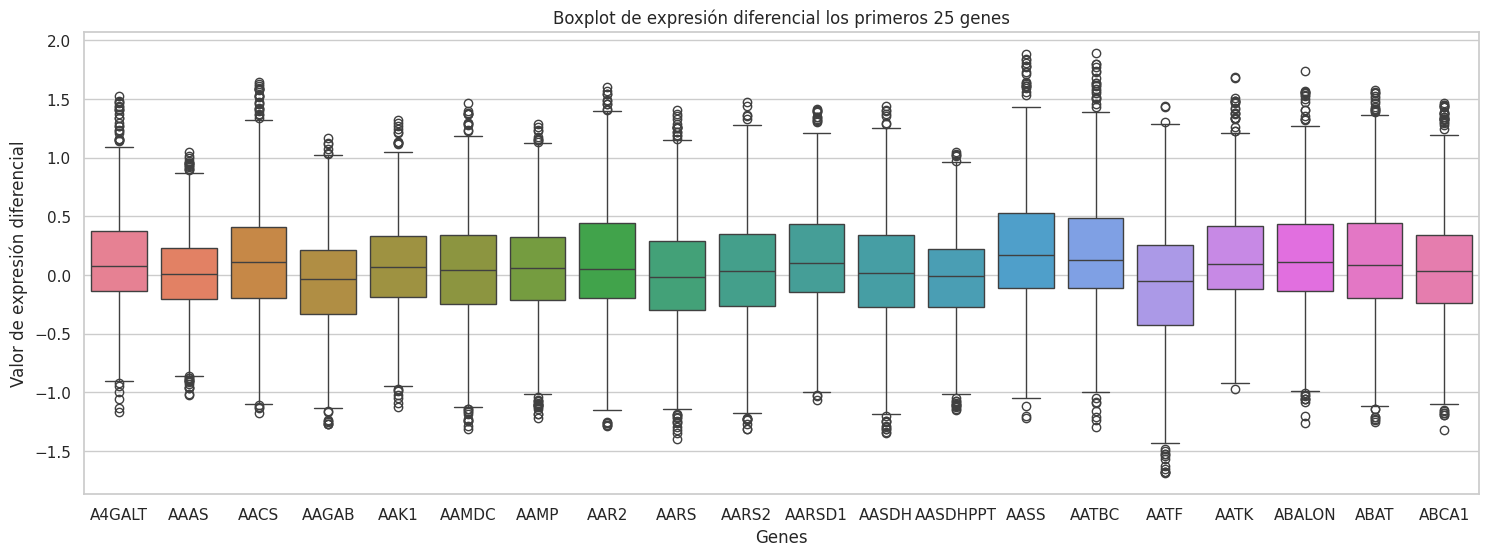

In [ ]:
plt.figure(figsize=(18, 6))
sns.boxplot(data=df_sin_outliers.iloc[:,5:25]).set(title='Boxplot de expresión diferencial los primeros 25 genes', xlabel='Genes', ylabel='Valor de expresión diferencial')
plt.show()



La mediana de la expresión diferencial sin incluir atípicos de los diferentes genes no están tan alejadas entre sí. Es notable que genes como AAAS y AASDHPPT tienen un rango de valores ligeramente más pequeño. Veamos la cantidad de valores atípicos por gen, de al menos los presentados en el gráfico.

In [ ]:
df_sin_outliers.isna().sum().sort_values(ascending=False)

,0
FTH1,123
FTL,107
TXNIP,105
DDX5,105
H1FX,104
...,...
STYX,26
ZNF121,26
RTP4,23
MRS2,23


Genes como FTH1, FTL y TXNIP son aquellas variables con más datos atípicos en la expresión diferencial: 123, 107 y 105 respectivamente. En cambio; RTP4 , MRS2 y CLASP2 son aquellos compuestos con menos outliers: 23, 23 y 22 respectivamente. También se destaca que todos los genes cuentan con expresiones diferenciales atípicas.

### adata_train

`adata_train` es un dataset que cuenta con 416442312 registros y 4 columnas. Es complemento de `de_train`

In [ ]:
adata_train.shape

(416442312, 4)

In [ ]:
adata_train

,obs_id,gene,count,normalized_count
0,000006a87ba75b72,AATF,1,5.567933
1,000006a87ba75b72,ABHD12,1,5.567933
2,000006a87ba75b72,ABHD3,1,5.567933
3,000006a87ba75b72,AC004687.1,1,5.567933
4,000006a87ba75b72,AC009779.2,1,5.567933
...,...,...,...,...
416442307,ffffe67500d95d8d,ZSWIM7,1,4.205181
416442308,ffffe67500d95d8d,ZSWIM8,1,4.205181
416442309,ffffe67500d95d8d,ZUP1,1,4.205181
416442310,ffffe67500d95d8d,ZXDB,1,4.205181


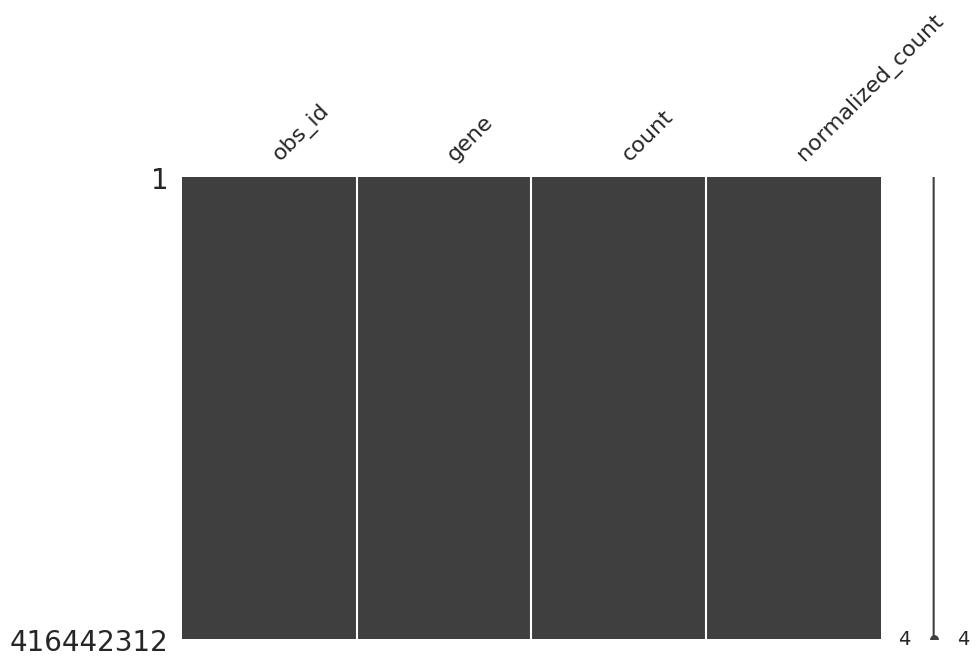

In [ ]:
msno.matrix(adata_train, figsize=(10, 6))
plt.show()

No existen datos faltantes.


In [ ]:
adata_train.describe(include = 'all')

,obs_id,gene,count,normalized_count
count,416442312,416442312,4.164423e+08,4.164423e+08
unique,240090,21255,NaN,NaN
top,0161fdbef3aa6b07,B2M,NaN,NaN
freq,6239,240088,NaN,NaN
mean,NaN,NaN,3.548138e+00,5.518731e+00
std,NaN,NaN,1.497948e+01,9.743412e-01
min,NaN,NaN,1.000000e+00,3.536117e+00
25%,NaN,NaN,1.000000e+00,5.041668e+00
50%,NaN,NaN,1.000000e+00,5.344550e+00
75%,NaN,NaN,2.000000e+00,5.825185e+00


In [ ]:
adata_train.columns

Index(['obs_id', 'gene', 'count', 'normalized_count'], dtype='object')

`obs_id` corresponde a un identificador único para cada una de las células en el conjunto de datos.

`gene` es la lista de genes correspondientes, que se alinea con las columnas de el dataset **de_train**.



In [ ]:
adata_train['gene'].value_counts()

,count
gene,
B2M,240088
RPL41,240087
MT-RNR2,240086
TPT1,240085
MALAT1,240082
...,...
RGS7,1
CLDN10,1
AL157895.1,1


`count` corresponden a los conteos crudos de moléculas para cada gen en cada célula, proporcionados por el software 10x CellRanger, que mide la cantidad de expresión génica en cada célula.

In [ ]:
adata_train['count'].describe()

,count
count,4.164423e+08
mean,3.548138e+00
std,1.497948e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,1.471000e+04


En promedio, el conteo crudo de moléculas para cada gen en las células es de aproximadamente 3.59, con una desviación estándar de 14.97, bastante alta en comparación con la media, lo que sugiere que hay una gran variabilidad en los conteos crudos de moléculas para los genes entre las diferentes células. Además, observando los percentiles, el 50% de los conteos crudos es menor a 1, el 25% se encuentra entre 1 y 2, y solo el 25% restante se encuentra entre 2 y 14710, un rango demasiado alto que refleja una gran variabilidad en ese 25% restante.

Además, la gran diferencia entre la mediana y el valor máximo, sugiere una distribución bastante asimétrica positiva, es decir, sesgada a la derecha, debido precisamente a estás células con conteos de expresión génica muy altos que están afectando la media. Esto taambién, lógicamente, ya da indicios de una alta presencia de datos atípicos.



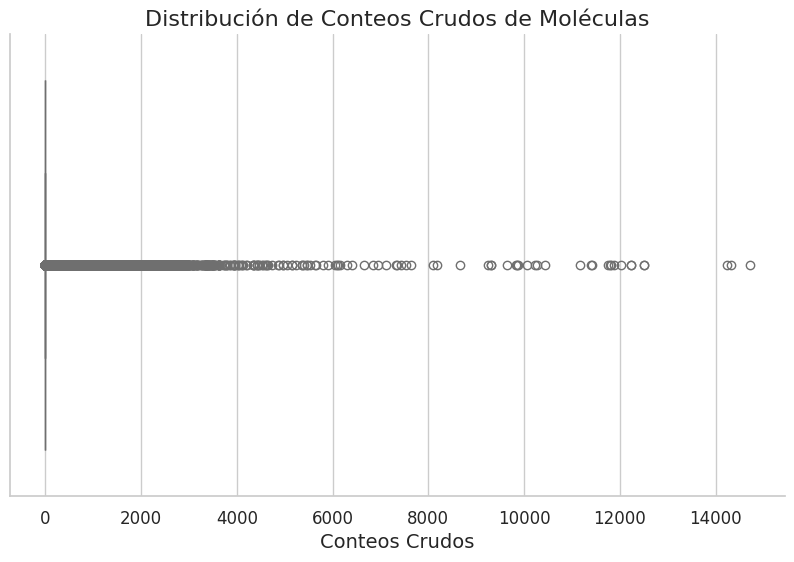

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=adata_train['count'], color='skyblue')
plt.title('Distribución de Conteos Crudos de Moléculas', fontsize=16)
plt.xlabel('Conteos Crudos', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
sns.despine()
plt.show()


Como era de esperarse, se aprecia una extrema concentración de datos a la izquierda de la gráfica, lo que confirma el sesgo a la derecha.

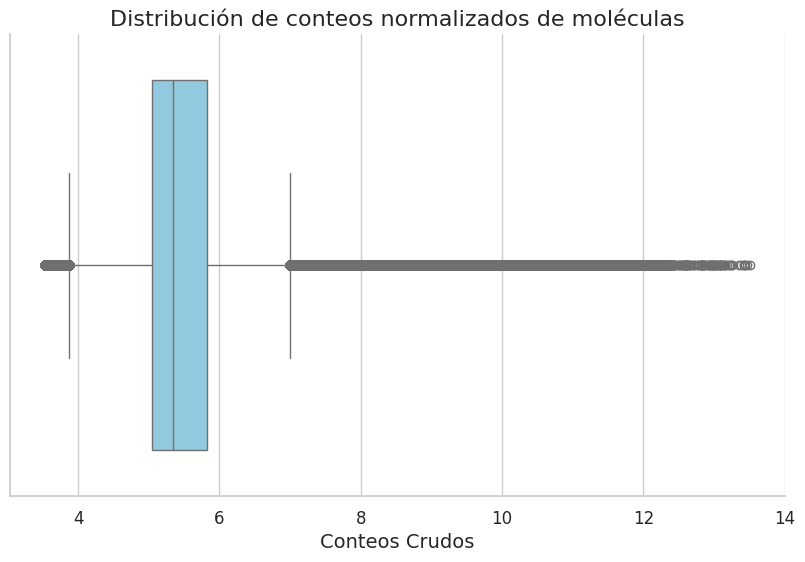

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=adata_train['normalized_count'], color='skyblue')
plt.title('Distribución de conteos normalizados de moléculas', fontsize=16)
plt.xlabel('Conteos Crudos', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
sns.despine()
plt.show()

In [ ]:
adata_train['normalized_count'].describe()

,normalized_count
count,4.164423e+08
mean,5.518731e+00
std,9.743412e-01
min,3.536117e+00
25%,5.041668e+00
50%,5.344550e+00
75%,5.825185e+00
max,1.350578e+01


`normalized_count` corresponden a conteos crudos que han sido normalizados y  transformados logarítmicamente (log(X+1)). Esto contribuye a manejar el sesgo que se presenta en la variable `count`, facilitando el análisis y la interpretación. Al igual que en la variable `count`, `normalized_count` también cuenta con datos atípicos.

Los conteos normalizados tiene registros desde 3.53 hasta 13.5, con una media de 5.5 (sd: 0.974) lo que sugiere una variabilidad moderada, muchísimo menor a la encontrada en `count`. Además, el 50% central de los datos se encuentran entre 5.04 y 5.88, con una mediana de 5.34 (RIQ: 0.78). El 25% superior de la distribución del conteo normalizado va desde 5.82 hasta 13.5, una diferencia de 7.68 entre los límites, lo que sugiere la gran dispersión en ese cuarto de los datos, y por supuesto el sesgo a la derecha.

### adata_obs_meta
`adata_obs_meta` contiene metadatos sobre las observaciones para el archivo `adata_train`.


In [ ]:
adata_obs

,obs_id,library_id,plate_name,well,row,col,cell_id,donor_id,cell_type,sm_lincs_id,sm_name,SMILES,dose_uM,timepoint_hr,control
0,000006a87ba75b72,library_4,plate_4,F7,F,7,PBMC,donor_2,T cells CD4+,LSM-4944,MLN 2238,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O,1.0,24,False
1,0000233976e3cd37,library_0,plate_3,D4,D,4,PBMC,donor_1,T cells CD4+,LSM-46203,BMS-265246,CCCCOc1c(C(=O)c2c(F)cc(C)cc2F)cnc2[nH]ncc12,1.0,24,False
2,0001533c5e876362,library_2,plate_0,B11,B,11,PBMC,donor_0,T regulatory cells,LSM-45663,Resminostat,CN(C)Cc1ccc(S(=O)(=O)n2ccc(/C=C/C(=O)NO)c2)cc1,1.0,24,False
3,00022f989630d14b,library_35,plate_2,E6,E,6,PBMC,donor_0,T cells CD4+,LSM-43216,FK 866,O=C(/C=C/c1cccnc1)NCCCCC1CCN(C(=O)c2ccccc2)CC1,1.0,24,False
4,0002560bd38ce03e,library_22,plate_4,B6,B,6,PBMC,donor_2,T cells CD4+,LSM-1099,Nilotinib,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,1.0,24,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240085,ffff28f274e983df,library_27,plate_0,G12,G,12,PBMC,donor_0,NK cells,LSM-3349,Mometasone Furoate,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,1.0,24,False
240086,ffff32893af5befb,library_31,plate_4,E7,E,7,PBMC,donor_2,T cells CD4+,LSM-2287,Midostaurin,CO[C@@H]1[C@H](N(C)C(=O)c2ccccc2)C[C@H]2O[C@]1...,1.0,24,False
240087,ffff6c3e0a7b05ad,library_38,plate_1,C5,C,5,PBMC,donor_2,NK cells,LSM-45786,BAY 87-2243,Cc1cc(-c2nc(-c3ccc(OC(F)(F)F)cc3)no2)nn1Cc1ccn...,1.0,24,False
240088,ffff8e571c7e8cb0,library_28,plate_5,B1,B,1,PBMC,donor_1,B cells,LSM-43181,Belinostat,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,0.1,24,True


In [ ]:
adata_obs.describe(include='all')

,obs_id,library_id,plate_name,well,row,col,cell_id,donor_id,cell_type,sm_lincs_id,sm_name,SMILES,dose_uM,timepoint_hr,control
count,240090,240090,240090,240090,240090,240090.00000,240090,240090,240090,240090,240090,240090,240090.000000,240090.0,240090
unique,240090,48,6,96,8,NaN,1,3,6,147,147,147,NaN,NaN,2
top,ffffe67500d95d8d,library_8,plate_4,A3,A,NaN,PBMC,donor_2,T cells CD4+,LSM-36361,Dimethyl Sulfoxide,C[S+](C)[O-],NaN,NaN,False
freq,1,6566,44550,4238,33695,NaN,240090,84442,124971,28462,28462,28462,NaN,NaN,161223
mean,NaN,NaN,NaN,NaN,NaN,6.05665,NaN,NaN,NaN,NaN,NaN,NaN,2.462781,24.0,NaN
std,NaN,NaN,NaN,NaN,NaN,3.55246,NaN,NaN,NaN,NaN,NaN,NaN,4.276144,0.0,NaN
min,NaN,NaN,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,0.100000,24.0,NaN
25%,NaN,NaN,NaN,NaN,NaN,3.00000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,24.0,NaN
50%,NaN,NaN,NaN,NaN,NaN,6.00000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,24.0,NaN
75%,NaN,NaN,NaN,NaN,NaN,9.00000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,24.0,NaN


Esta base de datos cuenta con 240090 registros y 15 variables entre categóricas y numéricas. La primera variable, `obs_id`, al igual que adata_train, corresponde a un identificador único para cada una de las células en el conjunto de datos.

`library_id` es un dentificador único para cada biblioteca, que representa una medición realizada en muestras agrupadas de cada fila de la placa. Todas las células de los pozos en la misma fila de la misma placa comparten un `library_id`. Existen 48 librerías diferentes.

In [ ]:
adata_obs['library_id'].value_counts().head()

,count
library_id,
library_8,6566
library_23,6328
library_22,6269
library_7,6095
library_10,6031


In [ ]:
adata_obs['library_id'].value_counts().tail()

,count
library_id,
library_42,4298
library_29,4145
library_43,4051
library_27,3857
library_6,3741


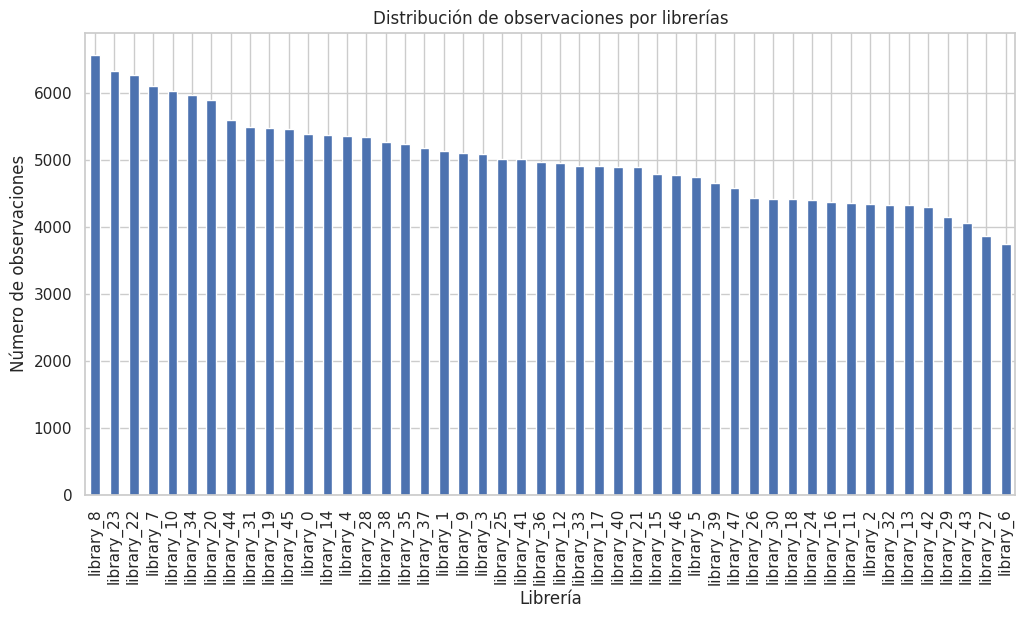

In [ ]:
plt.figure(figsize=(12, 6))
adata_obs['library_id'].value_counts().plot(kind='bar')
plt.title('Distribución de observaciones por librerías')
plt.xlabel('Librería')
plt.ylabel('Número de observaciones')
plt.show()


Las librerías con más células es la número 8 (6566), seguida de la 23 (6328), 22 (6269) y 7 (6095). Y la que contiene menos células, la 6 con 3741 observaciones y la 27 con 3857 células.

`plate_name`es un ID único para todas las muestras de la misma placa, en total existen 6 placas diferentes. La placa 4 es la que cuenta con más observaciones, mientra la placa 0 es la que menos observaciones tiene. Más adelante, se verá que influye en el número de observaciones por placa.


In [ ]:
adata_obs['plate_name'].value_counts()

,count
plate_name,
plate_4,44550
plate_3,41881
plate_1,39892
plate_5,39669
plate_2,37914
plate_0,36184


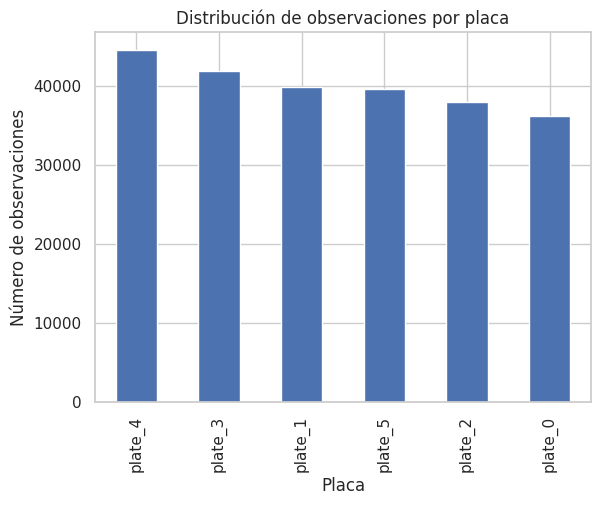

In [ ]:
adata_obs['plate_name'].value_counts().plot(kind='bar')
plt.title('Distribución de observaciones por placa')
plt.xlabel('Placa')
plt.ylabel('Número de observaciones')
plt.show()


 `well` hace referencia a la fila (`row`) concatenada con la columna (`col`) de cada observación, es decir, sus coordenadas en su placa. En total, existen 96 coordenadas, debido a que son 12 columnas enumeradas y 8 filas de la A a la H.

In [ ]:
adata_obs[['well', 'row', 'col']].head()


,well,row,col
0,F7,F,7
1,D4,D,4
2,B11,B,11
3,E6,E,6
4,B6,B,6


In [ ]:
adata_obs['well'].value_counts()

,count
well,
A3,4238
H3,4013
B3,3875
B2,3806
C3,3674
...,...
G12,1738
C10,1616
F7,1408


Los pozos con más observaciones corresponden a A3 (4238), H3 (4013) y B3 (3875). Por otro lado; F7, B10 y G10 son las que menos observaciones tienen con 1408, 1218 y 853 respectivamente. Se presenta un diagrama de barras con el número de observaciones por pozo.

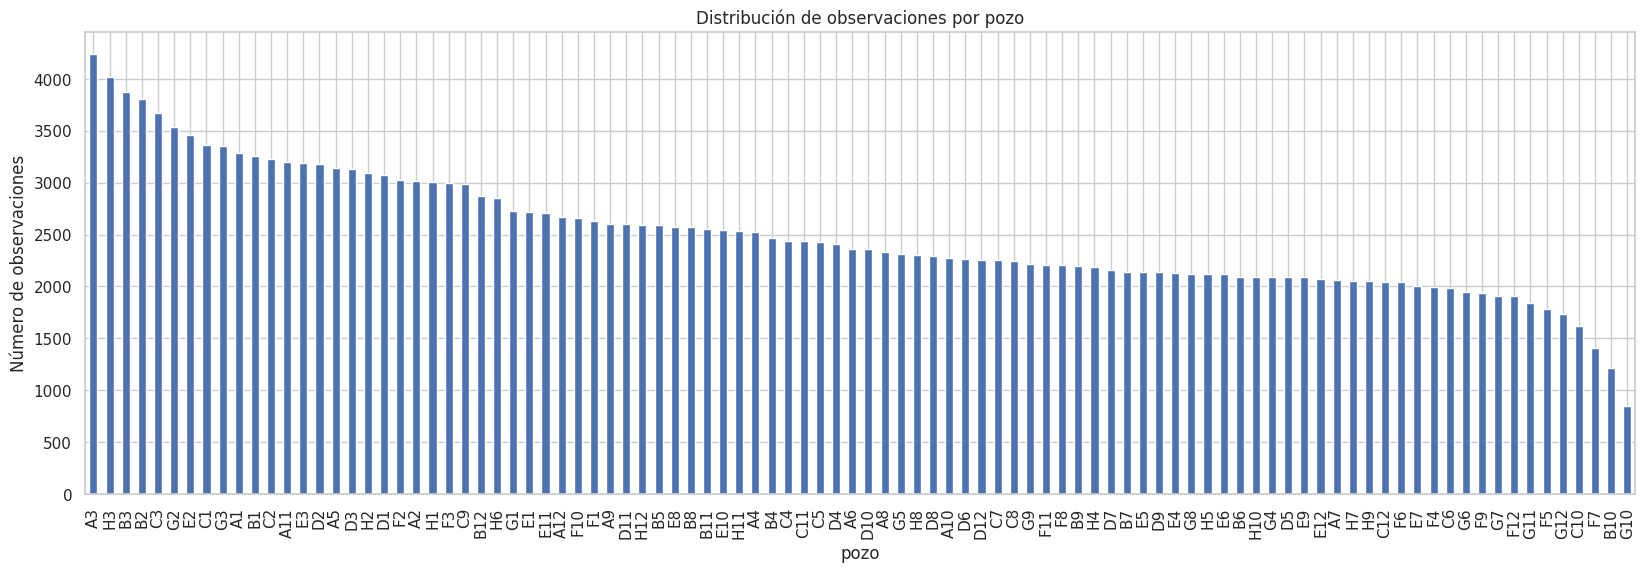

In [ ]:
plt.figure(figsize=(20, 6))
adata_obs['well'].value_counts().plot(kind='bar')
plt.title('Distribución de observaciones por pozo')
plt.xlabel('pozo')
plt.ylabel('Número de observaciones')
plt.show()

También hay una variable llamada `cell_id`, que tiene el mismo valor para todas las observaciones: PBMC, es decir, células mononucleares de sangre periférica, una colección de distintos tipos de células mencionados ya en el dataset `de_train` e incluidos en este dataset como `cell_type`. `donor_id` indica el donante del cual proviene la célula, en total son tres donantes.





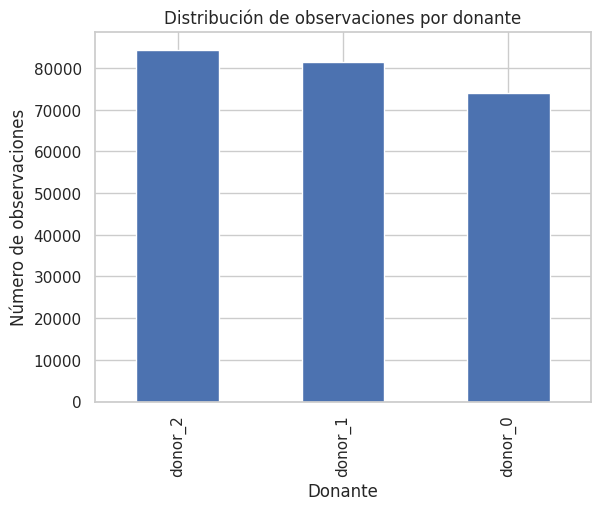

In [ ]:
adata_obs['donor_id'].value_counts().plot(kind='bar')
plt.title('Distribución de observaciones por donante')
plt.xlabel('Donante')
plt.ylabel('Número de observaciones')
plt.show()

Donde el tercer donante aportó una mayor cantidad de registros (84442), el segundo donante 81550 y el primer donante 74098.



`sm_lincs_id`, `sm_name` y `SMILES`	representan el ID global del compuesto en el sistema LINCS, nombre principal del compuesto y la estructura molecular en 1D del compuesto respectivamente. Este dataset cuenta con 147 compuestos diferentes, un compuesto más que en el dataset `de_train`.

In [ ]:
adata_obs['sm_name'].value_counts()

,count
sm_name,
Dimethyl Sulfoxide,28462
Dabrafenib,26346
Belinostat,24059
LDN 193189,1939
Porcn Inhibitor III,1900
...,...
ABT737,655
BMS-387032,416
UNII-BXU45ZH6LI,307


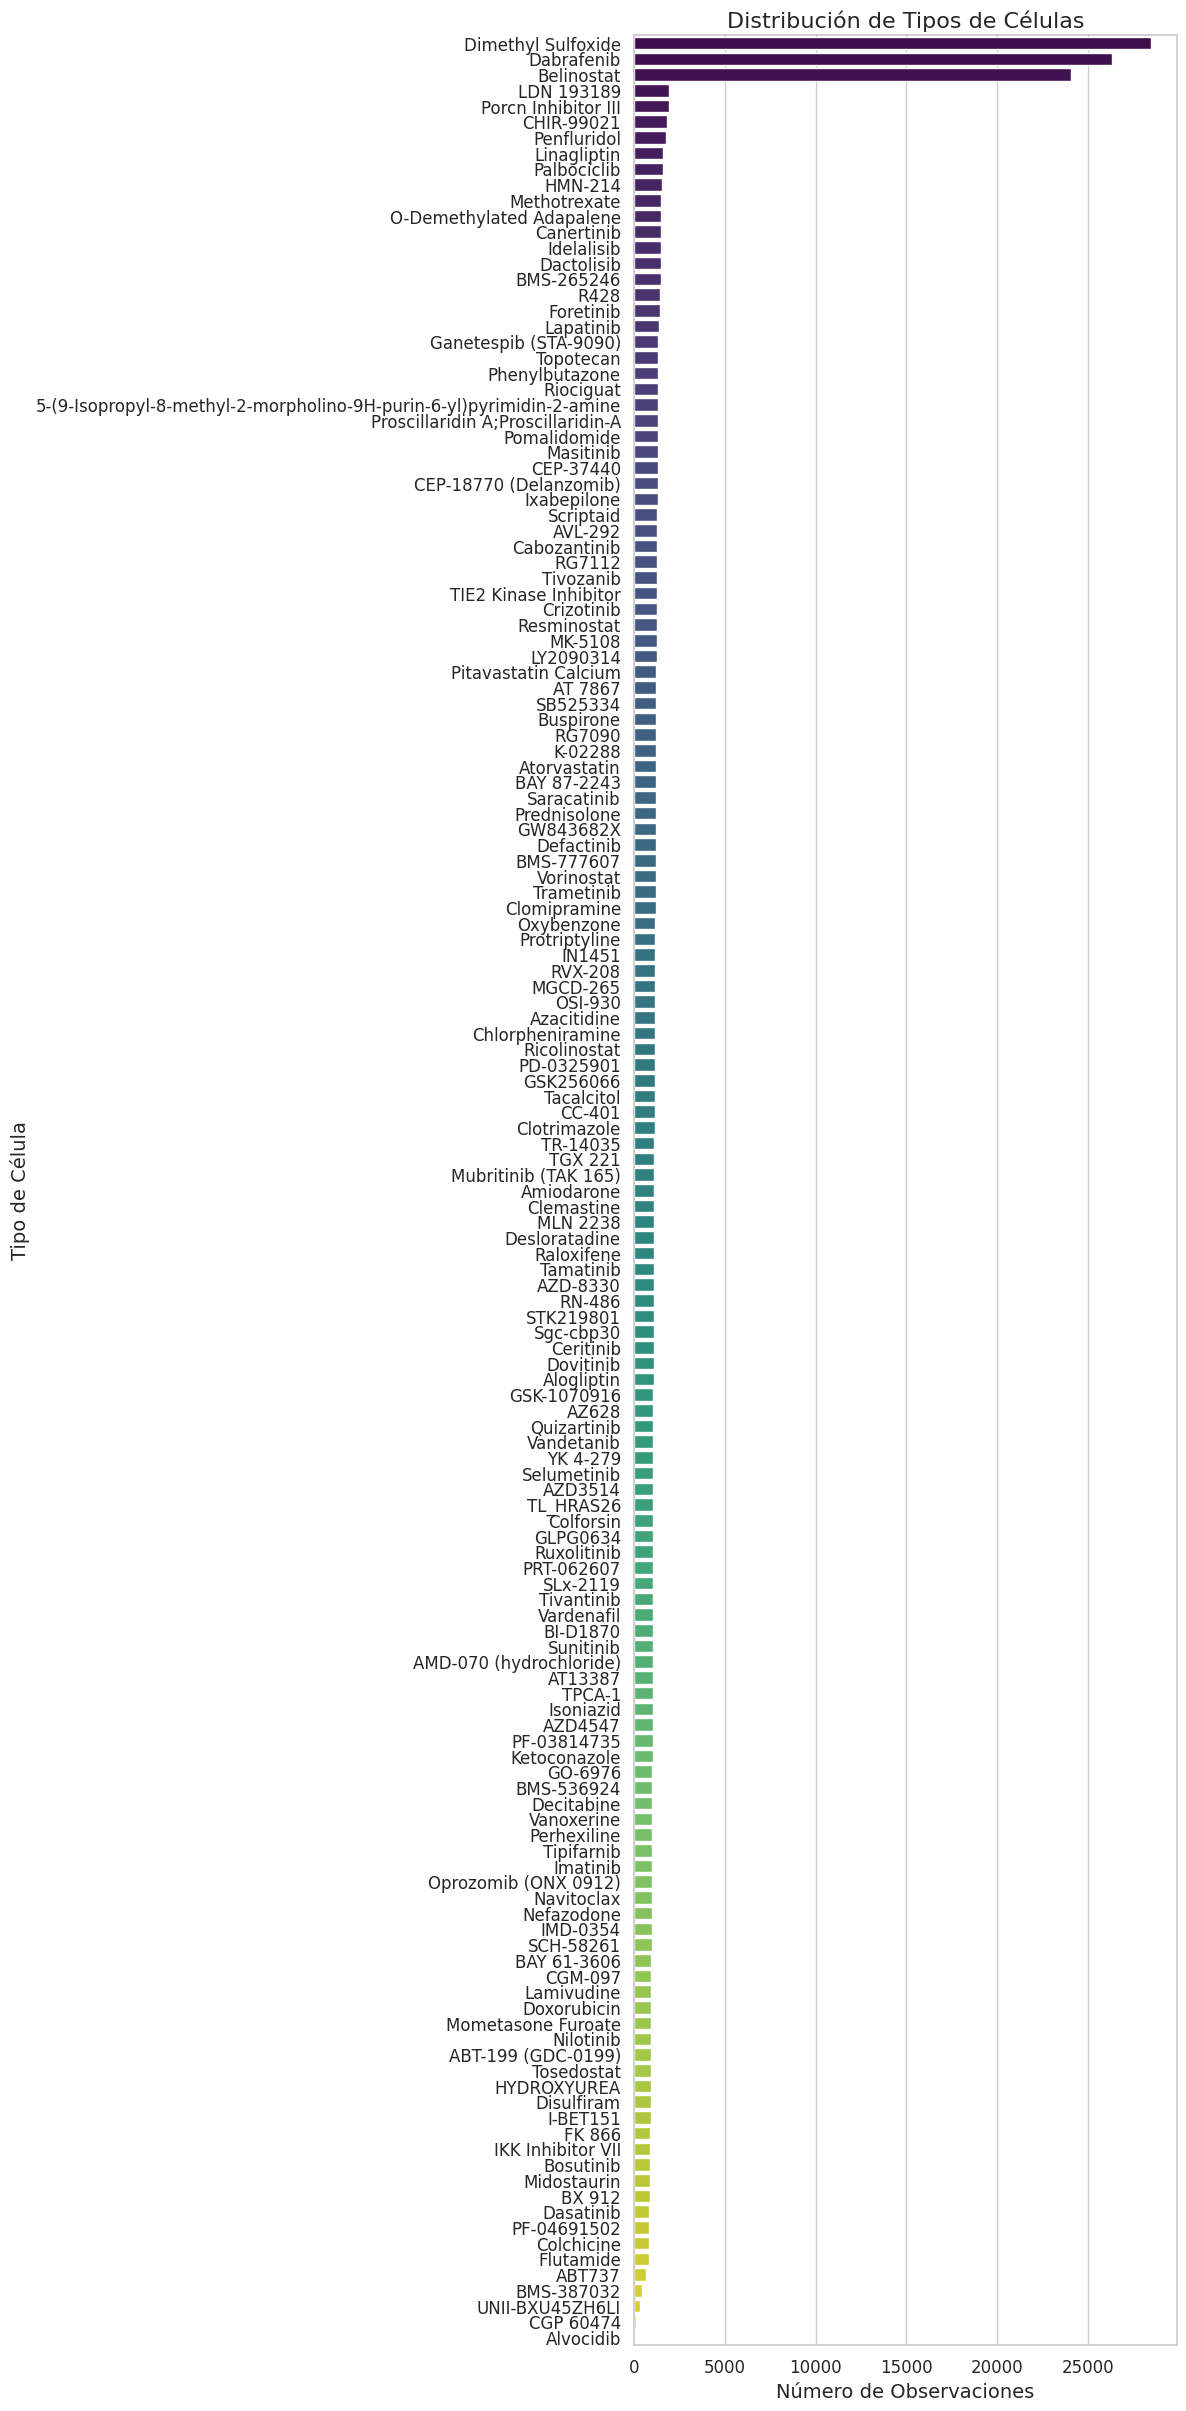

In [ ]:
sns.set(style='whitegrid')

plt.figure(figsize=(7, 30))
ax = sns.countplot(data=adata_obs, y="sm_name", order=adata_obs['sm_name'].value_counts().index, palette = 'viridis')

ax.set_title('Distribución de Tipos de Células', fontsize=16)
ax.set_xlabel('Número de Observaciones', fontsize=14)
ax.set_ylabel('Tipo de Célula', fontsize=14)


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [ ]:
set(adata_obs['sm_name']) - set(de_train['sm_name'])


{'Dimethyl Sulfoxide'}

Este compuesto es Dimethyl Sulfoxide (Dimetilsulfóxido) y es el compuesto con más registros en este dataset.

`dose_uM` es la dosis del compuesto en micromolar y `timepoint_hr` corresponde a la duración del tratamiento en horas.

In [ ]:
adata_obs['dose_uM'].describe()

,dose_uM
count,240090.000000
mean,2.462781
std,4.276144
min,0.100000
25%,1.000000
50%,1.000000
75%,1.000000
max,14.100000


Las dosis van desde un 0.1 micromolar hasta 14.1 micromolares (1/1.000.000 mol/l, es decir, una millonésima de peso molecular por litro).

En promedio, la dosis (en µM) es de aproximadamente 2.46, con una desviación estándar de 4.28, esta desviación sugiere una gran variabilidad en las dosis administradas. El 75% de los valores por debajo de 1 micromolar mientras que el 25% restante de los valores tienen dosis que van de 1 a 14.1 micromolares.

El hecho de que el rango de valores esté bastante extendido y el valor máximo sea significativamente más alto que la mediana indica una distribución sesgada a la derecha, o asimétrica positiva, y por tanto, la presencia de datos atípicos.



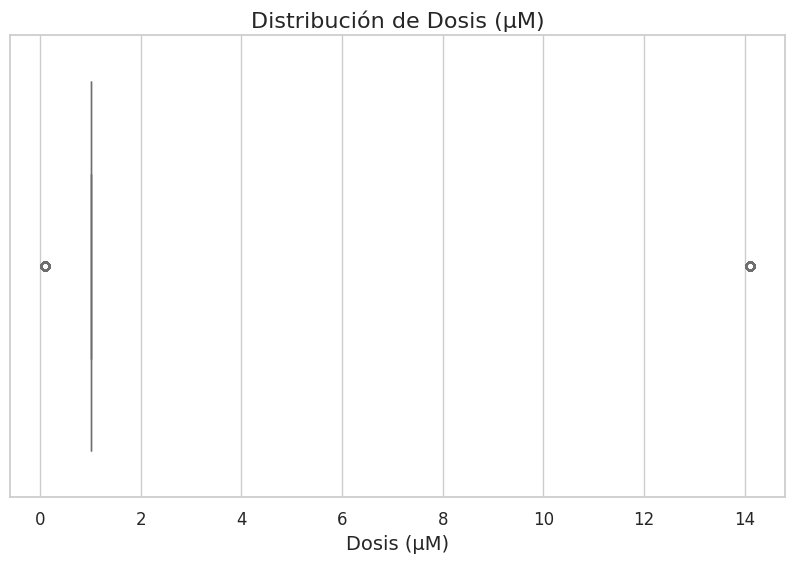

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=adata_obs['dose_uM'], color='skyblue')
plt.title('Distribución de Dosis (µM)', fontsize=16)
plt.xlabel('Dosis (µM)', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.show()


En la distribución parece que todos los componentes de la caja y bigotes están en el mismo punto.

In [ ]:
adata_obs['dose_uM'].value_counts()

,count
dose_uM,
1.0,187569
14.1,28462
0.1,24059


Es decir, solo se aplicaron dosis de 0.1, 1 y 14.1 micromolares.

Por último, la variable `timepoint_hr` no cambia, lo que quiere decir que el tratamiento duró 24 horas en cada célula.

#Análisis Bivariado

## Tipo de células por placas

<Figure size 1200x600 with 0 Axes>

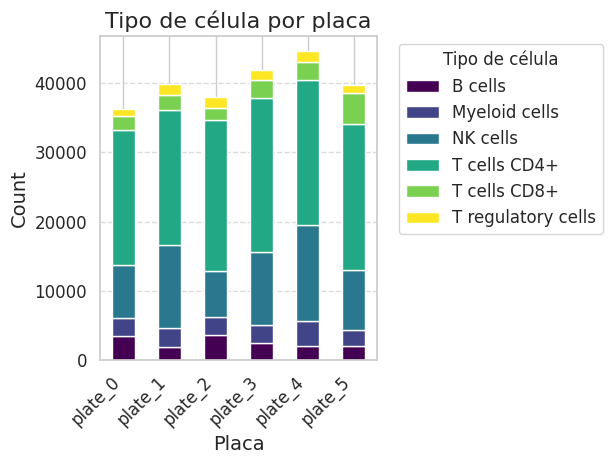

In [ ]:
sns.set(style="whitegrid")

gb = adata_obs.groupby(['plate_name', 'cell_type']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
ax = gb.plot(kind='bar', stacked=True, colormap='viridis')
plt.xlabel('Placa', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Tipo de célula por placa', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Tipo de célula', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
gb

cell_type,B cells,Myeloid cells,NK cells,T cells CD4+,T cells CD8+,T regulatory cells
plate_name,,,,,,
plate_0,3506,2609,7612,19540,1933,984
plate_1,1907,2785,11969,19355,2251,1625
plate_2,3573,2586,6751,21684,1732,1588
plate_3,2428,2678,10452,22323,2571,1429
plate_4,2037,3644,13787,20951,2619,1512
plate_5,2034,2359,8599,21118,4457,1102


Aquí se observa como varía la distribución de tipos de células por placa, esta distribución está bastante balanceada, no se nota una diferencia abrupta entre placas según el tipo de célula.

In [ ]:
total_cells_per_plate = gb.sum(axis=1)
gb_percentage = gb.div(total_cells_per_plate, axis=0) * 100
pd.DataFrame(gb_percentage)


cell_type,B cells,Myeloid cells,NK cells,T cells CD4+,T cells CD8+,T regulatory cells
plate_name,,,,,,
plate_0,9.689365,7.210369,21.036922,54.001769,5.342140,2.719434
plate_1,4.780407,6.981350,30.003509,48.518500,5.642735,4.073498
plate_2,9.423959,6.820699,17.806087,57.192594,4.568233,4.188426
plate_3,5.797378,6.394308,24.956424,53.301020,6.138822,3.412048
plate_4,4.572391,8.179574,30.947250,47.028058,5.878788,3.393939
plate_5,5.127429,5.946709,21.676876,53.235524,11.235474,2.777988


Acá se puede ver una representación porcentual de la composición de cada placa según el tipo célula, en todas predominan las células CD4+, sobre al menos el 47% por placa. En cambio, las células T reguladores representan una proporción menor respecto a las demás células en las seis placas.

## Recuento de tipo de células por donador

<Figure size 1200x600 with 0 Axes>

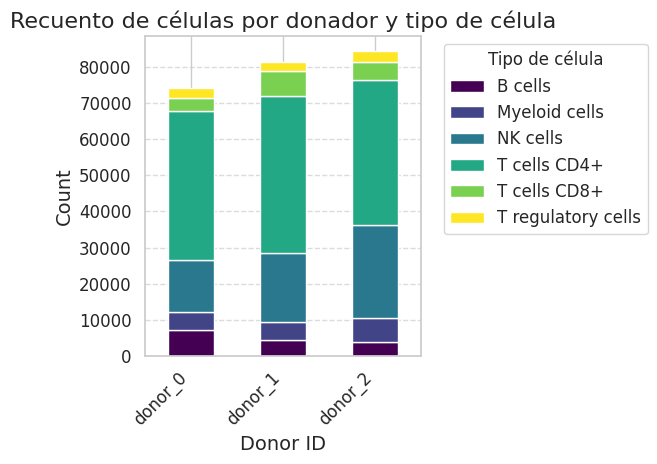

In [ ]:
sns.set(style="whitegrid")

gb = adata_obs.groupby(['donor_id', 'cell_type']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
ax = gb.plot(kind='bar', stacked=True, colormap='viridis')
plt.xlabel('Donor ID', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Recuento de células por donador y tipo de célula', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Tipo de célula', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
adata_obs.groupby(['donor_id', 'plate_name']).size().unstack(fill_value=0)

plate_name,plate_0,plate_1,plate_2,plate_3,plate_4,plate_5
donor_id,,,,,,
donor_0,36184,0,37914,0,0,0
donor_1,0,0,0,41881,0,39669
donor_2,0,39892,0,0,44550,0


Cada donador tiene dos placas, en el caso del primer donador sus placas corresponden a la número 0 y 2, el segundo donador tiene la numero 3 y 5, y por último, el tercer donador tiene la placa 1 y la placa 4.



In [ ]:
t = adata_obs.groupby(['plate_name', 'library_id']).size().unstack(fill_value=0)
t.apply(lambda x: ', '.join([i.split('_')[1] for i in x.index[x > 0]]), axis=1)

,0
plate_name,
plate_0,"11, 17, 2, 27, 29, 32, 34, 42"
plate_1,"15, 20, 21, 36, 38, 44, 46, 6"
plate_2,"12, 13, 19, 30, 33, 35, 43, 47"
plate_3,"0, 1, 10, 16, 18, 40, 8, 9"
plate_4,"22, 23, 3, 31, 37, 4, 5, 7"
plate_5,"14, 24, 25, 26, 28, 39, 41, 45"


Aquí se puede ver el número de librerías asociadas a cada placa, esto se puede relacionar también por las librerías correspondientes a cada donador.



## Expresión diferencial de genes por tipo de célula

In [ ]:
gi = ['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2MP1']
df_genes = de_train[['cell_type'] + ['sm_name'] + gi]

In [ ]:
df_genes

,cell_type,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1
0,NK cells,Clotrimazole,0.104720,-0.077524,-1.625596,-0.144545,0.143555
1,T cells CD4+,Clotrimazole,0.915953,-0.884380,0.371834,-0.081677,-0.498266
2,T cells CD8+,Clotrimazole,-0.387721,-0.305378,0.567777,0.303895,-0.022653
3,T regulatory cells,Clotrimazole,0.232893,0.129029,0.336897,0.486946,0.767661
4,NK cells,Mometasone Furoate,4.290652,-0.063864,-0.017443,-0.541154,0.570982
...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382
610,NK cells,Riociguat,-0.455549,0.188181,0.595734,-0.100299,0.786192
611,T cells CD4+,Riociguat,0.338168,-0.109079,0.270182,-0.436586,-0.069476
612,T cells CD8+,Riociguat,0.101138,-0.409724,-0.606292,-0.071300,-0.001789


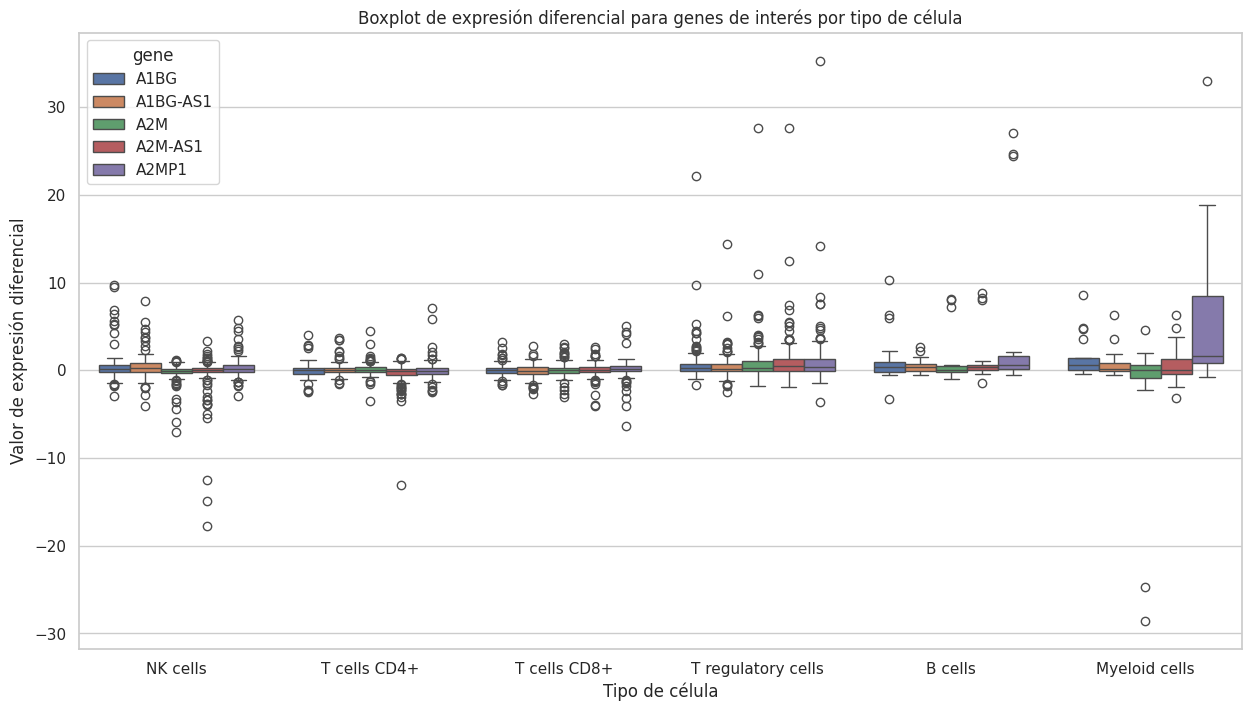

In [ ]:
dgm = df_genes.melt(id_vars=['cell_type', 'sm_name'],
                                 value_vars=gi,
                                 var_name='gene',
                                 value_name='value')

plt.figure(figsize=(15, 8))
sns.boxplot(x='cell_type', y='value', hue='gene', data=dgm)
plt.title('Boxplot de expresión diferencial para genes de interés por tipo de célula')
plt.xlabel('Tipo de célula')
plt.ylabel('Valor de expresión diferencial')
plt.show()


Se puede observar la presencia de datos átípicos en los valores de expresión diferencial según el tipo de célula. Llama la atención el rango más amplio de expresiones diferenciales para células mieloides en el gen A2MP1.

In [ ]:
# Créditos al profesor Lihki Rubio por la función.
def detect_outliers_zscore(data):
    outliers = []
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score = (i - mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers

In [ ]:
for i in df_genes.columns[2:]:
  ol = detect_outliers_zscore(df_genes[i])
  print(f'Valores atípicos para {i}: {ol}')
  print(f'Cantidad: {len(ol)}')

Valores atípicos para A1BG: [5.284535816691283, 6.834030214969075, 5.320014308151582, 9.71826132324907, 5.973633649564484, 9.715603212295601, 5.661062141398207, 22.08542786240399, 10.31277691747559, 8.559762174374034, 9.497700530185696, 6.289961831437638, 6.412666313450461]
Cantidad: 13
Valores atípicos para A1BG-AS1: [3.837147519578719, 4.3435329244008525, 6.2028214831661845, 7.865090429184831, 4.73957250333892, 6.284254595209316, 14.421991093023752, 5.478697059263874, -4.067518203195503]
Cantidad: 9
Valores atípicos para A2M: [-28.552191013539854, 11.0053643330047, 7.261230707428187, -24.687989996766042, -7.026508196144004, 27.557166046323935, 8.129455446522268, 7.968582584732241]
Cantidad: 8
Valores atípicos para A2M-AS1: [-14.893129353407211, 7.443065570978361, 12.411637528178435, 8.021801990492927, -17.8019892758402, -13.130321858906015, 27.60371487105479, 6.857447578223836, 8.806709134555478, -12.507873369159938, 8.244448941859416]
Cantidad: 11
Valores atípicos para A2MP1: [14.13

Haciendo uso del código del profesor para la detección de datos atípicos, notamos la presencia de varios datos átipicos en los genes seleccionados. Más adelante se revisará su presencia en todos los genes.

Veamos ahora, de manera más general, la expresión diferencial de los genes según el tipo de célula sin enfocarnos en algunos genes en particular.

In [11]:
expresion_media = de_train.groupby('cell_type').apply(lambda x: x.iloc[:, 5:].mean().mean()).reset_index(name='Expresión promedio')

In [12]:
expresion_media.sort_values(by='Expresión promedio', ascending=False)

,cell_type,Expresión promedio
1,Myeloid cells,1.177494
0,B cells,1.172690
5,T regulatory cells,0.488408
2,NK cells,0.412256
3,T cells CD4+,0.153794
4,T cells CD8+,0.032433


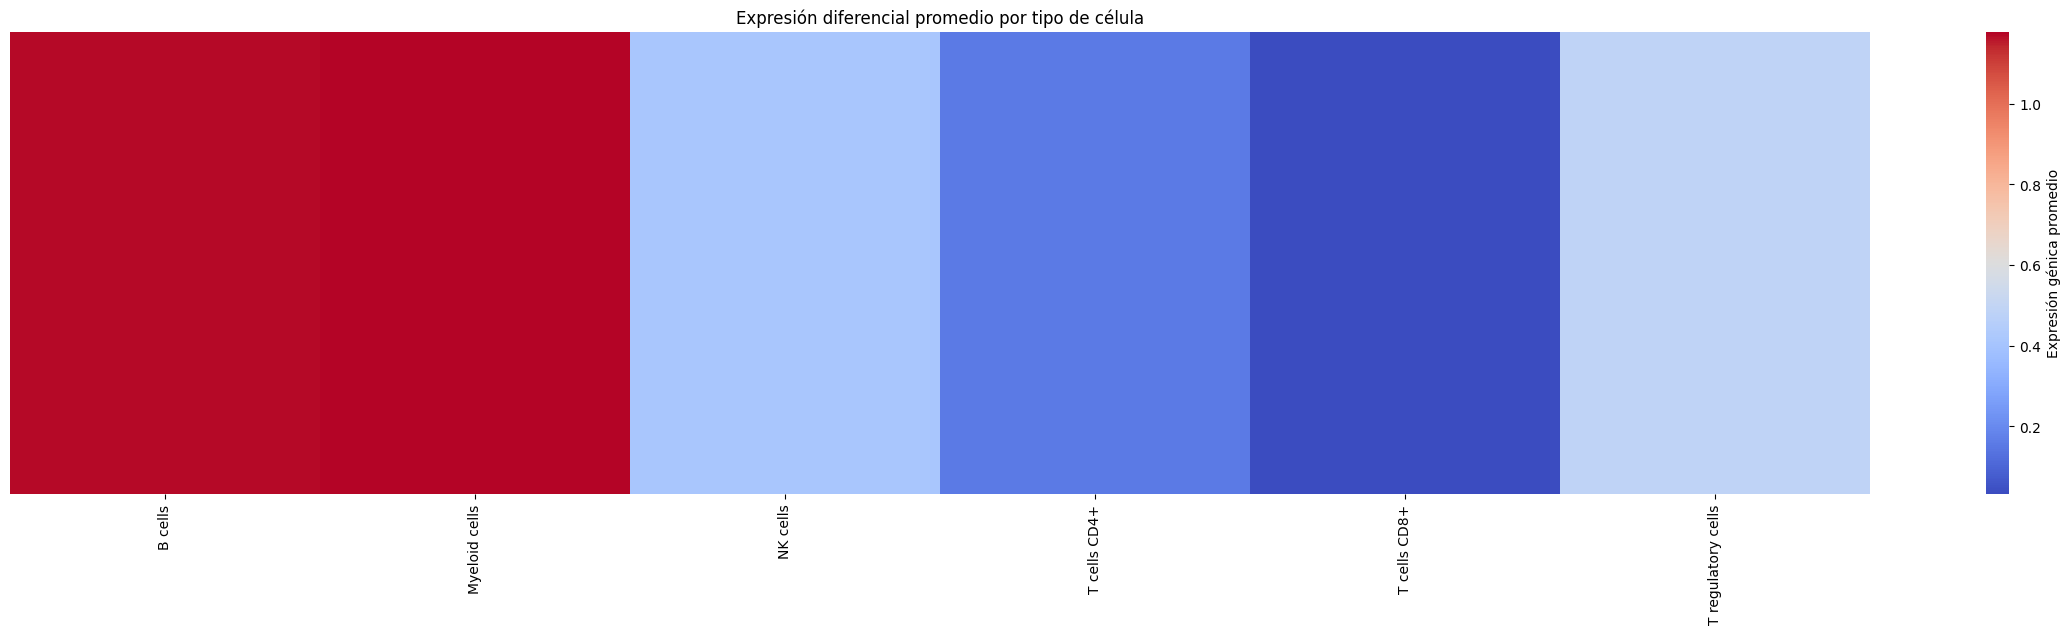

In [13]:
plt.figure(figsize=(30, 6))

sns.heatmap([expresion_media['Expresión promedio']], cmap='coolwarm', cbar_kws={'label': 'Expresión génica promedio'}, xticklabels=expresion_media['cell_type'], vmin=expresion_media['Expresión promedio'].min(), vmax=expresion_media['Expresión promedio'].max())

plt.title('Expresión diferencial promedio por tipo de célula')
plt.xticks(rotation=90)
plt.yticks([])

plt.show()


Es curioso como aquellas células de las que precisamente no se tienen tantos registros son las que presentan expresiones diferenciales génicas promedio más altas, seguidas de las células regulatorias T y las células NK con una expresión promedio de 0.488 y 0.412 respectivamente. En cambio lado, las T cells CD4+ y las T cells CD8+, de las más que cuentan con más observaciones en `de_train` presentan las expresiones promedio más bajas, con valores de 0.154 y 0.032, respectivamente.

## Expresión diferencial por compuesto

In [ ]:
expresion_media = de_train.groupby('sm_name').apply(lambda x: x.iloc[:, 5:].mean().mean()).reset_index(name='Expresión promedio')

In [ ]:
expresion_media.sort_values(by='Expresión promedio', ascending=False)

,sm_name,Expresión promedio
12,Alvocidib,4.956104
80,MLN 2238,3.587989
91,Oprozomib (ONX 0912),3.353552
31,CGP 60474,3.301680
28,CEP-18770 (Delanzomib),3.260143
...,...,...
82,Methotrexate,-0.163834
141,Vandetanib,-0.172184
116,Riociguat,-0.194342
76,Lapatinib,-0.201585


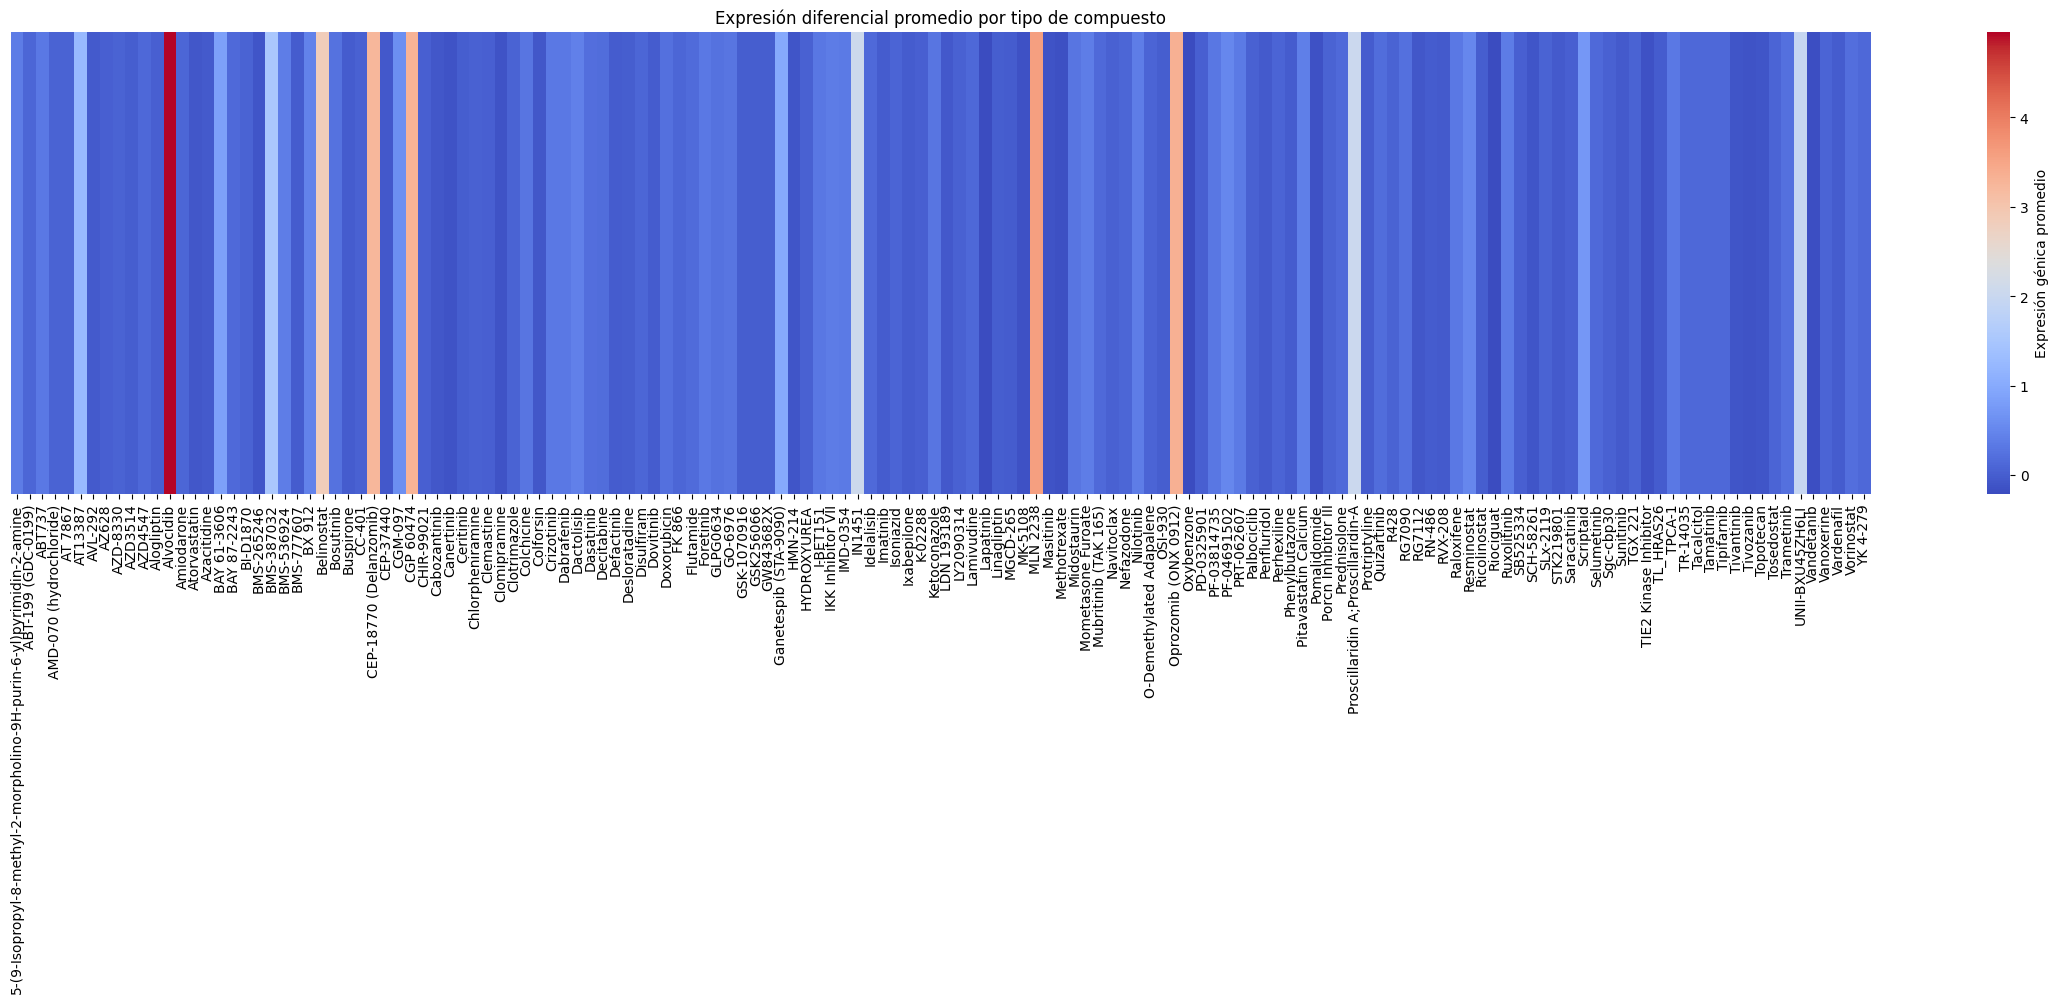

In [ ]:
plt.figure(figsize=(30, 6))

sns.heatmap([expresion_media['Expresión promedio']], cmap='coolwarm', cbar_kws={'label': 'Expresión génica promedio'}, xticklabels=expresion_media['sm_name'], vmin=expresion_media['Expresión promedio'].min(), vmax=expresion_media['Expresión promedio'].max())

plt.title('Expresión diferencial promedio por tipo de compuesto')
plt.xticks(rotation=90)
plt.yticks([])

plt.show()


La gran mayoría de compuestos cuentan con una expresión diferencial promedio en los genes inferior a 2.5. Sin embargo, compuestos como Alvocidib, MLN 2238, Oprozomib (ONX 0912), entre pocos otros, destacan por promedios es estas DE bastante mayores, es decir, parecen inducir una mayor actividad génica en las células. En cambio, compuestos como Oxybenzone, Lapatinib y Riociguat cuenta con expresiones génicas menores, incluso negativas, que sugieren una reducción de la actividad génica inducida por estas moléculas pequeñas.

# Limpieza: imputación y reducción de dimensionalidad

### Imputación de datos atípicos

A lo largo del análisis exploratorio de los datos, se pudo notar la presencia de ellos en la expresión diferencial de los genes. Además de, gráficamente, la aparente anormalidad de todos ellos. De todos modos, se verificará la normalidad de la expresión diferencial de los genes.

In [ ]:
def check_normality(df):
    normal_columns = []
    for column in df.columns[5:]:
        data = df[column]
        _, p_value = stats.shapiro(data)
        if p_value >= 0.05:
            normal_columns.append(column)
    return normal_columns

normal_cols = check_normality(de_train)
print(len(normal_cols))

0


Es decir, ninguna de los genes tiene una distribución de la expresión diferencial de los genes normal. Es por esto, que se hará imputación con la mediana. Se hizo el intento de usar IterativeImputer(), sin embargo, los recursos no fueron suficientes.

In [ ]:
def impute_outliers(df):
    for column in df.columns[5:]:
        data = df[column]

        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[column] = np.where((data < lower_bound) | (data > upper_bound), data.median(), data)


In [ ]:
de_train_imp = de_train.copy()
impute_outliers(de_train_imp)

In [ ]:
de_train_imp.describe(include='all')

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
count,614,614,614,614,614,614.000000,614.000000,614.000000,614.000000,614.000000,...,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
unique,6,146,146,146,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NK cells,Penfluridol,LSM-2334,OC1(c2ccc(Cl)c(C(F)(F)F)c2)CCN(CCCC(c2ccc(F)cc...,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,146,6,6,6,602,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.088363,0.111249,0.037877,0.087270,0.129633,...,-0.015463,0.060479,-0.056368,0.058255,0.198583,0.165752,0.152593,0.116508,-0.098306,-0.058010
std,NaN,NaN,NaN,NaN,NaN,0.500687,0.537476,0.430133,0.501572,0.546298,...,0.476573,0.535390,0.543998,0.519351,0.537817,0.516135,0.471284,0.493701,0.539453,0.490965
min,NaN,NaN,NaN,NaN,NaN,-1.270048,-1.424666,-1.166581,-1.367801,-1.389629,...,-1.332876,-1.415372,-1.517931,-1.363628,-1.304153,-1.166314,-1.117706,-1.152181,-1.590996,-1.365706
25%,NaN,NaN,NaN,NaN,NaN,-0.177102,-0.190342,-0.168035,-0.144079,-0.149290,...,-0.253441,-0.199999,-0.354655,-0.180747,-0.093180,-0.104605,-0.108308,-0.142971,-0.370305,-0.334123
50%,NaN,NaN,NaN,NaN,NaN,0.082722,0.102076,0.044717,0.036156,0.116411,...,0.010186,0.063539,-0.010158,0.065780,0.148876,0.145279,0.137559,0.062804,-0.083260,-0.058601
75%,NaN,NaN,NaN,NaN,NaN,0.341912,0.387859,0.232044,0.308295,0.386306,...,0.229929,0.319802,0.257794,0.328312,0.438525,0.385152,0.372393,0.397249,0.226954,0.212230


In [ ]:
de_train.describe(include = 'all')

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
count,614,614,614,614,614,614.000000,614.000000,614.000000,614.000000,614.000000,...,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
unique,6,146,146,146,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NK cells,Penfluridol,LSM-2334,OC1(c2ccc(Cl)c(C(F)(F)F)c2)CCN(CCCC(c2ccc(F)cc...,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,146,6,6,6,602,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.366769,0.250951,0.148259,0.155733,0.684275,...,0.071179,0.159252,0.018584,0.267114,0.497043,0.382672,0.240726,0.161087,-0.160735,-0.071255
std,NaN,NaN,NaN,NaN,NaN,1.634697,1.188660,2.275410,2.184095,3.189206,...,1.028842,1.128245,1.333236,1.439952,1.691722,1.430553,0.918039,0.779918,0.932961,0.748377
min,NaN,NaN,NaN,NaN,NaN,-3.258689,-4.067518,-28.552191,-17.801989,-6.378904,...,-4.309438,-4.276411,-21.273505,-5.520507,-6.780020,-2.617712,-8.310726,-3.456731,-7.189487,-4.819105
25%,NaN,NaN,NaN,NaN,NaN,-0.215161,-0.267728,-0.230129,-0.229460,-0.190989,...,-0.349490,-0.289498,-0.421265,-0.275030,-0.119912,-0.135779,-0.141982,-0.169364,-0.479099,-0.402733
50%,NaN,NaN,NaN,NaN,NaN,0.082722,0.102076,0.044717,0.036156,0.116411,...,0.010186,0.063539,-0.010158,0.065780,0.148876,0.145279,0.137559,0.062804,-0.083260,-0.058601
75%,NaN,NaN,NaN,NaN,NaN,0.528015,0.523162,0.405858,0.532216,0.616725,...,0.330117,0.479763,0.361876,0.482989,0.683587,0.600652,0.510566,0.487592,0.266170,0.252387


Revisemos nuevamente la gráfica realizada de la expresión diferencial de los primeros 20 genes, además de la expresión diferencial por tipo de célula.

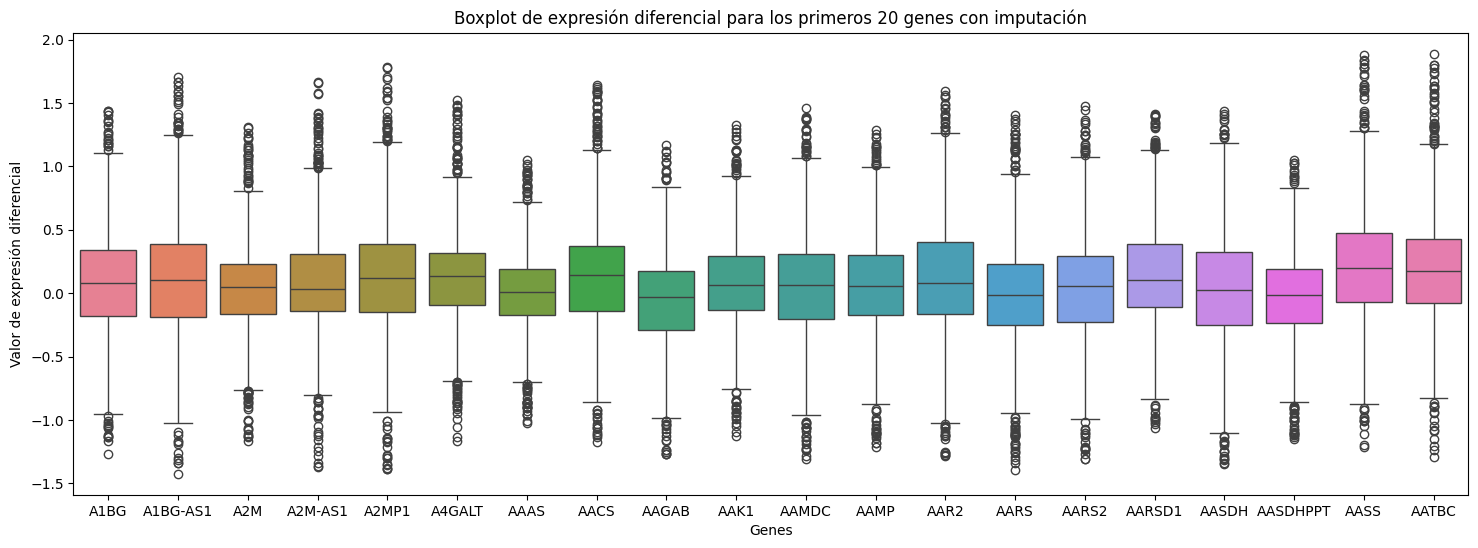

In [ ]:
plt.figure(figsize=(18, 6))
sns.boxplot(data=de_train_imp.iloc[:,5:25])
plt.title('Boxplot de expresión diferencial para los primeros 20 genes con imputación')
plt.xlabel('Genes')
plt.ylabel('Valor de expresión diferencial')
plt.show()

Se siguen observando la presencia de posibles datos atípicos, sin embargo ahora sí es posible ver con mejor claridad los tamaños de las cajas y bigotes, el análisis realizado en la gráfica similar anterior se mantiene, dado que la distribución de las cajas después de la imputación y la que no presentaba datos atípicos se mantuvo, a diferencia de la presencia de los outliers mostrada.

In [ ]:
gi = ['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2MP1']
df_genes = de_train_imp[['cell_type'] + ['sm_name'] + gi]

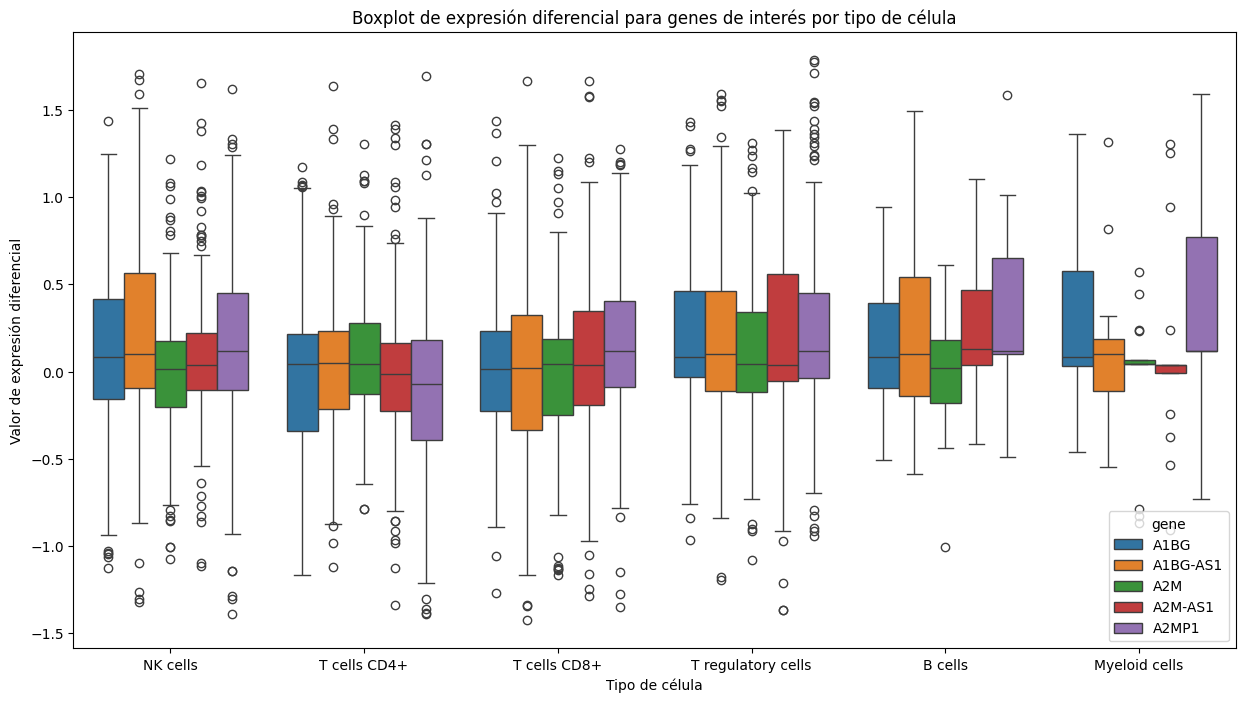

In [ ]:
dgm = df_genes.melt(id_vars=['cell_type', 'sm_name'],
                                 value_vars=gi,
                                 var_name='gene',
                                 value_name='value')

plt.figure(figsize=(15, 8))
sns.boxplot(x='cell_type', y='value', hue='gene', data=dgm)
plt.title('Boxplot de expresión diferencial para genes de interés por tipo de célula')
plt.xlabel('Tipo de célula')
plt.ylabel('Valor de expresión diferencial')
plt.show()

### Encoder


In [ ]:
cte = ['cell_type', 'sm_name']
dt_ss = de_train_imp[cte]

encoder = OneHotEncoder(sparse_output=False)
ed = encoder.fit_transform(dt_ss)

edf = pd.DataFrame(ed, columns=encoder.get_feature_names_out(cte))

de_train_f = pd.concat([edf, de_train_imp.drop(columns=cte)], axis=1)
de_train_f = de_train_f.drop(columns=['sm_lincs_id','SMILES', 'control'])
de_train_f

,cell_type_B cells,cell_type_Myeloid cells,cell_type_NK cells,cell_type_T cells CD4+,cell_type_T cells CD8+,cell_type_T regulatory cells,sm_name_5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine,sm_name_ABT-199 (GDC-0199),sm_name_ABT737,sm_name_AMD-070 (hydrochloride),...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,0.145279,-0.213550,0.415768,0.078439,-0.259365
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.549987,0.063539,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-0.058601


In [ ]:
edf

,cell_type_B cells,cell_type_Myeloid cells,cell_type_NK cells,cell_type_T cells CD4+,cell_type_T cells CD8+,cell_type_T regulatory cells,sm_name_5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine,sm_name_ABT-199 (GDC-0199),sm_name_ABT737,sm_name_AMD-070 (hydrochloride),...,sm_name_Tivozanib,sm_name_Topotecan,sm_name_Tosedostat,sm_name_Trametinib,sm_name_UNII-BXU45ZH6LI,sm_name_Vandetanib,sm_name_Vanoxerine,sm_name_Vardenafil,sm_name_Vorinostat,sm_name_YK 4-279
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
610,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
611,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
612,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Para realizar la codificación se tomaron las columnas `cell_type` y `sm_name` de los datos ya imputados `de_train_imp` y se codificaron utilizando One-Hot Encoding para convertirlas en variables numéricas. También se eliminaron las columnas categóricas no eran necesarias para el análisis final, como `sm_lincs_id`, `SMILES` y `control`.

### Multicolinealidad


Debido a que el objetivo del modelo a realizar es predecir cómo afectan el tipo de célula y el compuesto aplicado la expresión diferencial de los genes, aplicar VIF para la reducción de la multicolinealidad podría llevar a la eliminación de genes relevantes para nuestro análisis

In [ ]:
corr_matrix = de_train_f.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


In [ ]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print(to_drop)

['AATBC', 'AATK', 'ABALON', 'ABCA10', 'ABCA3', 'ABCA6', 'ABCA9', 'ABCB11', 'ABCB4', 'ABCB9', 'ABCC2', 'ABCG2', 'ABCG8', 'ABHD1', 'ABHD14A-ACY1', 'ABHD15-AS1', 'ABLIM2', 'ABO', 'ABTB2', 'AC000068.1', 'AC000123.2', 'AC000403.1', 'AC001226.2', 'AC002044.1', 'AC002044.2', 'AC002075.2', 'AC002091.2', 'AC002116.2', 'AC002128.1', 'AC002306.1', 'AC002310.2', 'AC002451.1', 'AC002470.1', 'AC002525.1', 'AC002543.1', 'AC002553.1', 'AC002553.2', 'AC002558.1', 'AC003005.2', 'AC003991.1', 'AC004000.1', 'AC004024.1', 'AC004057.1', 'AC004067.1', 'AC004069.1', 'AC004076.2', 'AC004130.1', 'AC004232.2', 'AC004241.3', 'AC004241.5', 'AC004381.2', 'AC004466.1', 'AC004491.1', 'AC004492.1', 'AC004528.1', 'AC004540.1', 'AC004584.3', 'AC004771.1', 'AC004771.3', 'AC004771.4', 'AC004801.6', 'AC004803.1', 'AC004816.1', 'AC004817.3', 'AC004825.2', 'AC004839.1', 'AC004846.1', 'AC004846.2', 'AC004854.2', 'AC004865.1', 'AC004877.2', 'AC004884.2', 'AC004890.2', 'AC004898.1', 'AC004908.2', 'AC004908.3', 'AC004918.3', 'AC

In [ ]:
len(to_drop)

7487

Además, para un dataframe tan grande como lo es de_train, no es práctico por el costo computacional que implica. También, preocupa la pérdida de información relevante para la construcción del modelo y correcta predicción de la expresión diferencial de los diferentes genes.

Si se realizara la eliminación, solo por aquellas variables con alta correlación (mayor a 0.9), se eliminarían 7487 genes.

# Punto 4: Modelos


## KNN

In [ ]:
def mrrmse(y_true, y_pred):
    rowwise_rmse = np.sqrt(np.mean((y_true - y_pred) ** 2, axis=1))
    return np.mean(rowwise_rmse)


In [ ]:
X = de_train_f.iloc[:,:152]
Y = de_train_f.iloc[:,152:]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsRegressor())
])

kf = KFold(n_splits=10, shuffle=True, random_state=10)

param_grid = {
    'knn__n_neighbors': list(range(1, 200)),
    'knn__metric': ['minkowski', 'euclidean', 'manhattan'],
    'knn__p': [1, 2, 3],
    'knn__weights': ['uniform', 'distance']
}

mrrmse_scorer = make_scorer(mrrmse, greater_is_better=False)

gs_knn = GridSearchCV(pipeline, param_grid, cv=kf, scoring=mrrmse_scorer, verbose=3, n_jobs=-1)
gs_knn.fit(X_train, y_train)

mejor_modelo = gs_knn.best_estimator_

y_pred_train = mejor_modelo.predict(X_train)
y_pred_test = mejor_modelo.predict(X_test)

mrrmse_test = mrrmse(y_test, y_pred_test)

trains = mejor_modelo.score(X_train, y_train)
tests = mejor_modelo.score(X_test, y_test)

print(f'Mejores parámetros: {gs_knn.best_params_}')
print(f'MRRMSE en el conjunto de entrenamiento: {gs_knn.best_score_}')
print(f'MRRMSE en el conjunto de prueba: {mrrmse_test}')


Fitting 10 folds for each of 3582 candidates, totalling 35820 fits
Mejores parámetros: {'knn__metric': 'minkowski', 'knn__n_neighbors': 115, 'knn__p': 1, 'knn__weights': 'distance'}
MRRMSE en el conjunto de entrenamiento: -0.5054605760763212
MRRMSE en el conjunto de prueba: 0.5154687652473766


El mejor modelo se realiza con la métrica minkowski con parámetro p = 1, 115 vecinos y tomando como peso la distancia. 

## Regresión lineal

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('lin_reg', LinearRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
trains = pipeline.score(X_train, y_train)
tests = pipeline.score(X_test, y_test)
print(f"Train score = {trains * 100:.2f}%")
print(f"Test score = {tests * 100:.2f}%")
print(f"MRRMSE: {mrrmse(y_test, y_pred)}")

Train score = 39.56%
Test score = -39.67%
MRRMSE: 0.6046578786151875


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=10)

def calcular_metricas(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mape, mae, mse, rmse, r2


y_pred_knn = mejor_modelo.predict(X_test)
y_pred_lr = pipeline.predict(X_test)

metricas_knn = calcular_metricas(y_test, y_pred_knn)
metricas_lr = calcular_metricas(y_test, y_pred_lr)

tabla_errores = pd.DataFrame({
    'Modelo': ['KNN', 'Regresión Lineal'],
    'MAPE': [metricas_knn[0], metricas_lr[0]],
    'MAE': [metricas_knn[1], metricas_lr[1]],
    'MSE': [metricas_knn[2], metricas_lr[2]],
    'RMSE': [metricas_knn[3], metricas_lr[3]],
    'R2': [metricas_knn[4], metricas_lr[4]]
})

tabla_errores

,Modelo,MAPE,MAE,MSE,RMSE,R2
0,KNN,180.017519,0.089539,0.062331,0.249661,0.769500
1,Regresión Lineal,780.916604,0.348260,0.213588,0.462156,0.204598


Al revisar las métricas especificadas en la tabla, MAPE, MAE, MSE y RMSE, métricas asociadas al error, son menores en el modelo K-NN, indicando un mejor ajueste en este. Además, el modelo 115-NN también presenta un coeficiente de determinación mayor: 76,95%, es decir, explica alrededor del 77% de la variabilidad en la expresión diferencial de los distintos genes. En cambio, el modelo de regresión lineal presenta errores mayores y solo explica el 20% de la variabilidad de los datos.